# Detrending Light Curve Data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo
from scipy.interpolate import interp1d
from matplotlib.widgets import Slider, Button


print(f"exoplanet.__version__ = '{xo.__version__}'")

exoplanet.__version__ = '0.5.1'


In [4]:
def tic_id_from_simbad(other_id):
    #takes other_id (string) and queries Simbad to obtain the TIC ID
    
    from astroquery.simbad import Simbad
    ID_table = Simbad.query_objectids(other_id)
    if ID_table == None:
        return(None)
    
    ID_table['ID'] = ID_table['ID'].astype(str)
    

    ID_pandas = ID_table.to_pandas()
    tic_id = ID_pandas[ID_pandas['ID'].str.contains("TIC")]
    
    
    return tic_id['ID'].values[0]

In [5]:
def transit_info_from_exoplanet_archive(tic_id):
    #takes TIC ID and queries exoplanet archive to return t0, period, and duration
    
    import pyvo as vo
    import pandas as pd


    service = vo.dal.TAPService("https://exoplanetarchive.ipac.caltech.edu/TAP")
    a = service.search("SELECT \
                       tic_id, pl_tranmid, pl_orbper, pl_trandur\
                       FROM pscomppars")
    exoplanets = a.to_table()
    exoplanets = exoplanets.to_pandas()
    
    #rename columns
    column_dict = {
    'pl_tranmid':'t0 [BJD]',
    'pl_orbper':'period [days]',
    'pl_trandur':'duration [hours]',
    }
    
    exoplanets.rename(columns=column_dict, inplace=True)
    
    result = exoplanets[exoplanets['tic_id'] == tic_id]

    
    #if there's no row in the planetary comparison table, check TOI table
    if result.empty:
        print("Exoplanet Archive: TOI Table")
        print("----------------------------")
        print("")
        a = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=toi&select=tid,pl_tranmid,pl_orbper,pl_trandurh&format=csv"

        exoplanets = pd.read_csv(a)
        
        #rename columns
        column_dict = {
        'tid':'tic_id',
        'pl_tranmid':'t0 [BJD]',
        'pl_orbper':'period [days]',
        'pl_trandurh':'duration [hours]',
        }
        
        exoplanets.rename(columns=column_dict, inplace=True)
        exoplanets['tic_id'] = 'TIC ' + exoplanets['tic_id'].astype(str)
        
        result = exoplanets[exoplanets['tic_id'] == tic_id]
        
        
    else:
        print("Exoplanet Archive: Planet Comparison Table")
        print("------------------------------------------")
        print("")
        
    

    return result
    
    



In [6]:
def get_transit_info(planet_id):
    #takes a id, queries Simbad to get matching TIC ID
    #then queries exoplanet archive to extract t0, period, and duration
    #if no Simbad match found, then returns None and prints error message
    #if no exoplanet archive match found, then returns None and prints error message

    tic_id = tic_id_from_simbad(planet_id)
    if tic_id != None:
        transit_info = transit_info_from_exoplanet_archive(tic_id)
        if transit_info.empty:
            print("No TIC ID match found on exoplanet archive")
            return None
        
        else:
            return transit_info
            
    else:
        print("No TIC ID match found on Simbad")
        return None

In [7]:
def find_nearest(array, value):
    #returns the value in an array closest to another input value
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [8]:
def get_light_curve(planet_id, flux_type, TESS = False, Kepler = False):
    import numpy as np
    import lightkurve as lk
    from astropy.io import fits

    transit_info = get_transit_info(planet_id)
    if type(transit_info) == None:
        return None
    
    print(transit_info)
    
    tic_id = str(transit_info['tic_id'].values[0])
    periods = np.array(transit_info['period [days]'].values, dtype = float)
    t0s = np.array(transit_info['t0 [BJD]'].values, dtype = float)
    durations = np.array(transit_info['duration [hours]'].values, dtype = float)
    
    nplanets = len(periods)
    
    if TESS:
        #switch to TESS BJD
        t0s = t0s - 2457000
        
        #pull in TESS SPOC LC
        lc_files = lk.search_lightcurve(
            tic_id, mission='TESS', author = 'SPOC'
        ).download_all(quality_bitmask="hardest", flux_column=flux_type)
        
    if Kepler:
        #switch to Kepler BJD
        t0s = t0s - 2454833
        
        #pull in Kepler LC
        lc_files = lk.search_lightcurve(
            tic_id, mission='Kepler'
        ).download_all(quality_bitmask="hardest", flux_column=flux_type)
        
    

    lc = lc_files.stitch().remove_nans()
    
    xs = lc.time.value
    ys = lc.flux
    ys_err = lc.flux_err
    



    mask = np.zeros(np.shape(xs), dtype=bool)
    for ii in range(0, nplanets):
        masks = lc.create_transit_mask(period=periods[ii], duration=durations[ii]/24.*1.3, transit_time=t0s[ii])
        mask += masks
    

    lc_transit = lc[mask]
    
    xs_transit = lc_transit.time.value
    ys_transit = lc_transit.flux
    ys_err_transit = lc_transit.flux_err
    
    
    
    lc_star = lc[~mask]
    
    xs_star = lc_star.time.value
    ys_star = lc_star.flux
    ys_err_star = lc_star.flux_err

    min_time = xs.min()
    max_time = xs.max()

    
    t0s_all = []
    for ii in range(0, nplanets):
        t0 = t0s[0]
        period = periods[0]
        while t0 > min_time:
            t0 -= period

        
        while t0 < max_time:
            t0s_all.append(t0)
            t0 += period
    
    
    t0s_in_data = []
    for t0 in t0s_all:
        nearest_lc_time = find_nearest(xs, t0)
        if np.abs(t0 - nearest_lc_time) < 0.1: # 2.5 hours ~ 0.1 days
            t0s_in_data.append(t0)
            
            
    mu = np.mean( ys_star )
    ys_transit = ( ys_transit / mu - 1 )
    ys_star = ( ys_star / mu - 1 )
    ys_err_transit = ( ys_err_transit / mu )
    ys_err_star = ( ys_err_star / mu )
            
    
    
    

    
    return \
        np.array(xs_star), np.array(ys_star), np.array(ys_err_star), \
        np.array(xs_transit), np.array(ys_transit), np.array(ys_err_transit), \
        np.array(t0s_in_data), periods, durations, mask
    
    



In [9]:
def moving_median(time, flux, flux_err, time_window, sigma_window):
    '''
    input:
    time = array of time values
    flux = array of flux values
    flux_err = array of flux error values
    mask = array of mask values
    time_window = int, how many data points (in time space) around which to determine median on
    sigma_window = int, how many sigmas to clip
    
    
    returns:
    data:
        time_no_outliers = array of time values without outliers defined by moving median removed
        flux_no_outliers = array of flux values without outliers defined by moving median removed
        flux_no_outliers = array of flux error values without outliers defined by moving median removed
        mask_no_outliers = array of mask values without outliers defined by moving median removed
        time = array of all times to plot moving median
        moving_median = moving median value as array and length(flux) and length(time)
        time_outliers = array of time outliers defined by moving median removed
        flux_outliers = array of flux outliers defined by moving median removed
        flux_outliers = array of flux error outliers defined by moving median removed
        percent_outliers = percent of points that are outliers
    '''
    
    if len(time) != len(flux):
        print('error, mismatched time and flux data length')
    
    time_no_outliers = []
    flux_no_outliers = []
    flux_err_no_outliers = []
    
    moving_median = []
    
    time_outliers = []
    flux_outliers = []
    flux_err_outliers = []
    data = []
    for ii in range(0, len(time)):
        current_time = time[ii]
        current_flux = flux[ii]
        current_flux_err = flux_err[ii]
        
        indices = np.where(np.logical_and(time>=current_time-time_window, time<=current_time+time_window))[0]
        current_flux_median = np.median(flux[indices])
        moving_median.append(current_flux_median)
        


        if current_flux+sigma_window*current_flux_err >= current_flux_median and current_flux-sigma_window*current_flux_err <= current_flux_median:
            time_no_outliers.append(current_time)
            flux_no_outliers.append(current_flux)
            flux_err_no_outliers.append(current_flux_err)
            
        else:
            time_outliers.append(current_time)
            flux_outliers.append(current_flux)
            flux_err_outliers.append(current_flux_err)
            
    percent_outliers = np.round(100*(len(time_outliers) / (len(time_outliers)+len(time_no_outliers))),2)
    
    
    time_no_outliers = np.array(time_no_outliers)
    flux_no_outliers = np.array(flux_no_outliers)
    flux_err_no_outliers = np.array(flux_err_no_outliers)
        
    time_outliers = np.array(time_outliers)
    flux_outliers = np.array(flux_outliers)
    flux_err_outliers = np.array(flux_err_outliers)
    
    moving_median = np.array(moving_median)
    
    order = np.argsort(time_no_outliers)
    time_no_outliers = time_no_outliers[order]
    flux_no_outliers = flux_no_outliers[order]
    flux_err_no_outliers = flux_err_no_outliers[order]
    
    order = np.argsort(time)
    time = time[order]
    moving_median = moving_median[order]
    
    order = np.argsort(time_outliers)
    time_outliers = time_outliers[order]
    flux_outliers = flux_outliers[order]
    flux_err_outliers = flux_err_outliers[order]
    
    
    data = [time_no_outliers, flux_no_outliers, flux_err_no_outliers, time, moving_median, time_outliers, flux_outliers, flux_err_outliers, percent_outliers]

    return data

        

In [10]:
def plot_outliers(moving_median_data):
    '''
    input:
    data:
        time_no_outliers = array of time values without outliers defined by moving median removed
        flux_no_outliers = array of flux values without outliers defined by moving median removed
        flux_err_no_outliers = array of flux error values without outliers defined by moving median removed
        mask_no_outliers = array of mask values without outliers defined by moving median removed
        time_all = array of all times to plot moving median
        moving_median = moving median value as array and length(flux) and length(time)
        time_outliers = array of time outliers defined by moving median removed
        flux_outliers = array of flux outliers defined by moving median removed
        flux_outliers = array of flux error outliers defined by moving median removed
        percent_outliers = percent of points that are outliers
    '''
    
    [time_no_outliers, flux_no_outliers, flux_err_no_outliers, mask_no_outliers, \
    time_all, moving_median, \
    time_outliers, flux_outliers, flux_err_outliers, 
    percent_outliers] = moving_median_data
    

    
    fig, ax = plt.subplots(1, 1, figsize = [18,6])
    ax.plot(time_no_outliers, flux_no_outliers, '.', color = '#381c5e', alpha = 0.5)
    ax.plot(time_outliers, flux_outliers, '.', color = '#ca3d7a', alpha = 0.5)
    ax.plot(time_all, moving_med, color = 'black', linestyle = 'dotted')
    ax.set_xlabel("time [days]")
    ax.set_ylabel("intensity")

        
    fig.tight_layout()
    fig.show()
    
    return None

In [11]:
def plot_individual_lc(xs_star, ys_star, xs_transit, ys_transit, t0s_in_data, window, period, problem_times):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxed in transit
    #t0s_in_data = midtransits in data
    #window = what fraction of the period to plot on either side of transit (ie. window=1/2 means 1/2 period on either side)
    #period = planet period to define plotting limit
    
    fig, ax = plt.subplots(nrows = len(t0s_in_data), figsize = [9,3*len(t0s_in_data)])
    plt.subplots_adjust(left=0.2, bottom=0.1, hspace = 0.3)

    problem_times = []

    t_init = 0

    ts=[]
    ys=[]
    ls=[]
    if len(t0s_in_data) > 1:
        for ii in range(0, len(t0s_in_data)):

            y=np.arange(-.01, .01, 0.00001)
            ys.append(y)
            
            t = t_init*np.ones(np.shape(y))
            ts.append(t)
            
            ls.append(ax[ii].plot(t, y, lw=2, color='red')[0])
            
            t0 = t0s_in_data[ii]
            ax[ii].plot(xs_star, ys_star, '.', color = '#381c5e', alpha = 0.5)
            ax[ii].plot(xs_transit, ys_transit, '.', color = '#777acd', alpha = 0.5)
            [ax[ii].axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
            [ax[ii].axvline(_x, linewidth=1, color='r') for _x in problem_times]
            ax[ii].set_xlabel("time [days]")
            ax[ii].set_ylabel("intensity")
            ax[ii].set_xlim(t0-(period*window), t0+(period*window))
    
    else:
        y=np.arange(-.01, .01, 0.00001)
        ys.append(y)

        t = t_init*np.ones(np.shape(y))
        ts.append(t)

        ls.append(ax[ii].plot(t, y, lw=2, color='red')[0])
            
        t0 = t0s_in_data[0]
        ax.plot(xs_star, ys_star, '.', color = '#381c5e')
        ax.plot(xs_transit, ys_transit, '.', color = '#777acd')
        [ax.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
        [ax[ii].axvline(_x, linewidth=1, color='r') for _x in problem_times]
        ax.set_xlabel("time [days]")
        ax.set_ylabel("intensity")
        ax.set_xlim(t0-(period*window), t0+(period*window))
        
        

    axtime = plt.axes([0.1, 0.1, 0.036, 0.779])
    stime = Slider(axtime, 'time', np.min(xs_star), np.max(xs_star), valinit=t_init, orientation="vertical")

    def update(val):
        for ii in range(0, transits):
            ls[ii].set_xdata(val*np.ones(np.shape(ys[ii])))


        fig.canvas.draw_idle()

    stime.on_changed(update)

    resetax = plt.axes([0.8, 0.025, 0.13, 0.04])
    button = Button(resetax, 'save time', color='0.97', hovercolor='0.79')

    def save(event):
        if stime.val not in problem_times:
            problem_times.append(stime.val)


    button.on_clicked(save)

    plt.show()
        
    
    return fig

In [12]:
def plot_transit(xs_star, ys_star, xs_transit, ys_transit, t0, period, problem_times_input=None):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxed in transit
    #t0 = midtransit
    #period = planet period to define plotting limit
    
    global problem_times
    
    if problem_times_input == None:
        problem_times = []
        
    else:
        problem_times_input.sort()
        problem_times = problem_times_input
        
        
    window = 1./2.
    
    fig, ax = plt.subplots(1,1, figsize = [9,6])
    plt.subplots_adjust(left=0.2, bottom=0.3, hspace = 0.3)


    t_init = 0

    y = np.arange(-.03, .03, 0.000001)

    t = t_init*np.ones(np.shape(y))

    l = ax.plot(t, y, lw=2, color='red')[0]


    xmin, xmax = t0-(period*window)[0], t0+(period*window)[0]
    ymin, ymax = 1.2*np.min(ys_star), 1.2*np.max(ys_star)
    
    ax.plot(xs_star, ys_star, '.', color = '#381c5e')
    ax.plot(xs_transit, ys_transit, '.', color = '#777acd')
    ax.axvline(t0, linewidth=1, color='k')
    ax.set_xlabel("time [days]")
    ax.set_ylabel("intensity")
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)


    axtime = plt.axes([0.197, 0.1, 0.702, 0.09])
    stime = Slider(axtime, 'time', xmin, xmax, valinit=t_init, orientation="horizontal")

    def update(val):
        l.set_xdata(val*np.ones(np.shape(y)))

        fig.canvas.draw_idle()

    stime.on_changed(update)

    save_time = plt.axes([0.8, 0.025, 0.13, 0.04])
    button = Button(save_time, 'save time', color='0.97', hovercolor='0.79')

    def save(event):
        global problem_times
        if stime.val not in problem_times:
            problem_times.append(stime.val)
            problem_times.sort()


    button.on_clicked(save)
    

    fig.show()

    return(stime, button)



In [13]:
def plot_transits(xs_star, ys_star, xs_transit, ys_transit, t0s, period, problem_times_input=None):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxed in transit
    #t0s = midtransits in data
    #period = planet period to define plotting limits
    
    sliders, buttons = [], []

    for ii in range(0, len(t0s)):
        t0 = t0s[ii]
        slider, button = plot_transit(xs_star, ys_star, xs_transit, ys_transit, t0, period, problem_times_input)
        sliders.append(slider)
        buttons.append(button)
    
    return sliders, buttons


In [14]:
def trim_jump_times(x, y, yerr, mask, t0s, period, jump_times):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxed in transit
    #t0 = midtransit
    #period = planet period to define plotting limit
    #jump_times = jump times to trim data around (one before and one after each transit)
    
    x_epochs = []
    y_epochs = []
    yerr_epochs = []
    mask_epochs = []
    
    epoch_splits = []
    for ii in range(0, len(jump_times)-1):
        jump_start = jump_times[ii]
        jump_end = jump_times[ii+1]
        
        if ii % 2 == 0:
            jump_start = find_nearest(x, jump_start)
            jump_end = find_nearest(x, jump_end)
            
            epoch_split = [jump_start, jump_end]

            start_index = int(np.where(x == epoch_split[0])[0])
            end_index = int(np.where(x == epoch_split[1])[0])
            
            x_epochs.append(x[start_index:end_index])
            y_epochs.append(y[start_index:end_index])
            yerr_epochs.append(yerr[start_index:end_index])
            mask_epochs.append(mask[start_index:end_index])


    
    return x_epochs, y_epochs, yerr_epochs, mask_epochs
        
        
    
        
    
    

In [15]:
def plot_detrended_lc(x, ys, detrend_labels, t0s_in_data, window, period, colors, figname=None):
    '''
    inputs:
    x = times
    ys = [detrended light curves] of length N number of detrendings
    detrend_labels = [detrending type] of length N number of detrendings
    t0s_in_data = midtransits in data
    window = what fraction of the period to plot on either side of transit (ie. window=1/2 means 1/2 period on either side)
    period = planet period to define plotting limit
    colors = [colors] of length N number of detrendings
    figname = Name of file if you want to save figure
    
    return:
    None
    
    
    
    
    
    '''
    import math
    
    n_transit = np.arange(0, len(t0s_in_data), 1)
    
    if len(ys) > 1:
        fig, ax = plt.subplots(ncols = 3, nrows = math.ceil(len(t0s_in_data)/3), figsize = [18,len(t0s_in_data)*len(ys)/2])
    else:
        fig, ax = plt.subplots(ncols = 3, nrows = math.ceil(len(t0s_in_data)/3), figsize = [18,len(t0s_in_data)*len(ys)])

    
    y_detrend = []
    ndetrend = 0
    detrend_offset = 0
    
    
    for detrend_index in range(0, len(ys)):
        
        y_detrend = ys[detrend_index]
        
        #add offset for plotting purposes
        y_detrend += detrend_offset
        
        if len(t0s_in_data) > 1:
            column = 0
            row = 0
            for ii in range(0, len(t0s_in_data)):
                ax_ii = ax[row][column]

                t0 = t0s_in_data[ii]
                ax_ii.plot(x, y_detrend, 'o', color = colors[detrend_index], 
                            alpha = 0.5, label = detrend_labels[detrend_index])
                [ax_ii.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
                ax_ii.set_xlabel("time [days]")
                ax_ii.set_ylabel("intensity")
                ax_ii.set_xlim(t0-(period*window), t0+(period*window))
                ax_ii.set_ylim(-0.01, 0.01*len(ys))
                ax_ii.tick_params(axis='x', rotation=45)
                ax_ii.text(t0-(period*window)+.18, detrend_offset+.0018, 
                           detrend_labels[detrend_index], 
                           color=colors[detrend_index], fontsize=13)
                
                if column == 2:
                    column = 0
                    row += 1
                else:
                    column += 1
                    

        else:
            t0 = t0s_in_data[0]
            ax.plot(x, y_detrend, 'o', color = colors[detrend_index], 
                    alpha =0.5, label = detrend_labels[detrend_index])
            [ax.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
            ax.set_xlabel("time [days]")
            ax.set_ylabel("intensity")
            ax.set_xlim(t0-(period*window), t0+(period*window))
            ax.set_ylim(-0.01, 0.01*len(ys)+.01)
            ax.tick_params(axis='x', rotation=45)
            ax_ii.text(t0-(period*window)+.18, detrend_offset+.0018, 
                        detrend_labels[detrend_index], 
                        color=colors[detrend_index], fontsize=13)
                            
        
        #subtract offset off as lists are changed globally in functions
        y_detrend -= detrend_offset
        
        ndetrend += 1
        detrend_offset += 0.01
        
    
    
    if figname:
        fig.savefig(figname)
    fig.show()
    
    

    
    return None

In [16]:
def split_around_transits(x, y, yerr, mask, t0s, window, period, model = 'None'):
    #x = time
    #y = flux 
    #yerr = flux error
    #mask = mask
    #t0s = midtransits in data
    #window = what fraction of the period to plot on either side of transit (ie. xlim=1/2 means 1/2 period on either side)
    #period = planet period to define plotting limit
    
    
    
    #print(model)
    #print(x)
    
    xlims = []
    x_split = []
    y_split = []
    yerr_split = []
    mask_split = []
    
    if type(model) is np.ndarray:
        model_split = []
        
    for t0 in t0s:
        xlims.append([float(t0-(period*window)), float(t0+(period*window))])
        x_split.append([])
        y_split.append([])
        yerr_split.append([])
        mask_split.append([])
        
        if type(model) is np.ndarray:
            model_split.append([])
        
        
        
    print(x)
    split_index = 0
    for xlim in xlims:
        for ii in range(0, len(x)):
            time = x[ii]
            lc = y[ii]
            lc_err = yerr[ii]
            transit_mask = mask[ii]
            
            if type(model) is np.ndarray:
                model_val = model[ii]
                #print(model_val)
            
            
            if time >= xlim[0] and time <= xlim[1]:
                
                
                x_split[split_index].append(time)
                y_split[split_index].append(lc)
                yerr_split[split_index].append(lc_err)
                mask_split[split_index].append(transit_mask)
                
                if type(model) is np.ndarray:
                    model_split[split_index].append(model_val)
                    
        split_index += 1
    
    if type(model) is np.ndarray:
        return np.array(x_split), np.array(y_split), np.array(yerr_split), np.array(mask_split),  np.array(model_split)
        
    return np.array(x_split), np.array(y_split), np.array(yerr_split), np.array(mask_split) 
        
        

In [17]:
def plot_lc(xs_star, ys_star, xs_transit, ys_transit, t0s_in_data, problem_times):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxes in transit
    #t0s_in_data = midtransits in data
    #xlim = what fraction of the period to plot on either side of transit (ie. xlim=2 means 1/2 perio on either side)
    
    fig, ax = plt.subplots(1, 1, figsize = [9,3])
    ax.plot(xs_star, ys_star, '.', color = '#381c5e', alpha = 0.5)
    ax.plot(xs_transit, ys_transit, '.', color = '#777acd', alpha = 0.5)
    [ax.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
    [ax.axvline(_x, linewidth=1, color='r') for _x in problem_times]
    ax.set_xlabel("time [days]")
    ax.set_ylabel("intensity")

        
    fig.tight_layout()
    fig.show()
    
    return None

In [18]:
def plot_phase_fold_lc(time, lc, period, t0s, xlim):
    
    plt.figure(figsize = [18,6])
    x_fold = (
        time - t0s[0] + 0.5 * period
    ) % period - 0.5 * period
    plt.scatter(x_fold, lc, c=time, s=10)
    plt.xlabel("time since transit [days]")
    plt.ylabel("intensity [ppm]")
    plt.colorbar(label="time [days]")
    _ = plt.xlim(0.-(period/xlim), 0.+(period/xlim))

In [19]:
def recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star):
   
    time_all = np.concatenate((time_transit, time_star))
    lc_all = np.concatenate((lc_transit, lc_star))
    lc_err_all = np.concatenate((lc_err_transit, lc_err_star))
    
    order = np.argsort(time_all)
    time_all = time_all[order]
    lc_all = lc_all[order]
    lc_err_all = lc_err_all[order]
    
    return(time_all, lc_all, lc_err_all)
    
    

In [21]:
#kepler 1513 = koi-3678
#kepler 1519 = koi-3762
time_star, lc_star, lc_err_star, \
time_transit, lc_transit, lc_err_transit, \
t0s, period, duration, mask = get_light_curve('koi-3678', 'sap_flux', Kepler=True)

/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/astropy/table/table.py:3197: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


Exoplanet Archive: Planet Comparison Table
------------------------------------------

            tic_id      t0 [BJD]  period [days]  duration [hours]
921  TIC 394177315  2.455111e+06     160.884651           10.7536


In [22]:
x, y, yerr = recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star)



<IPython.core.display.Javascript object>


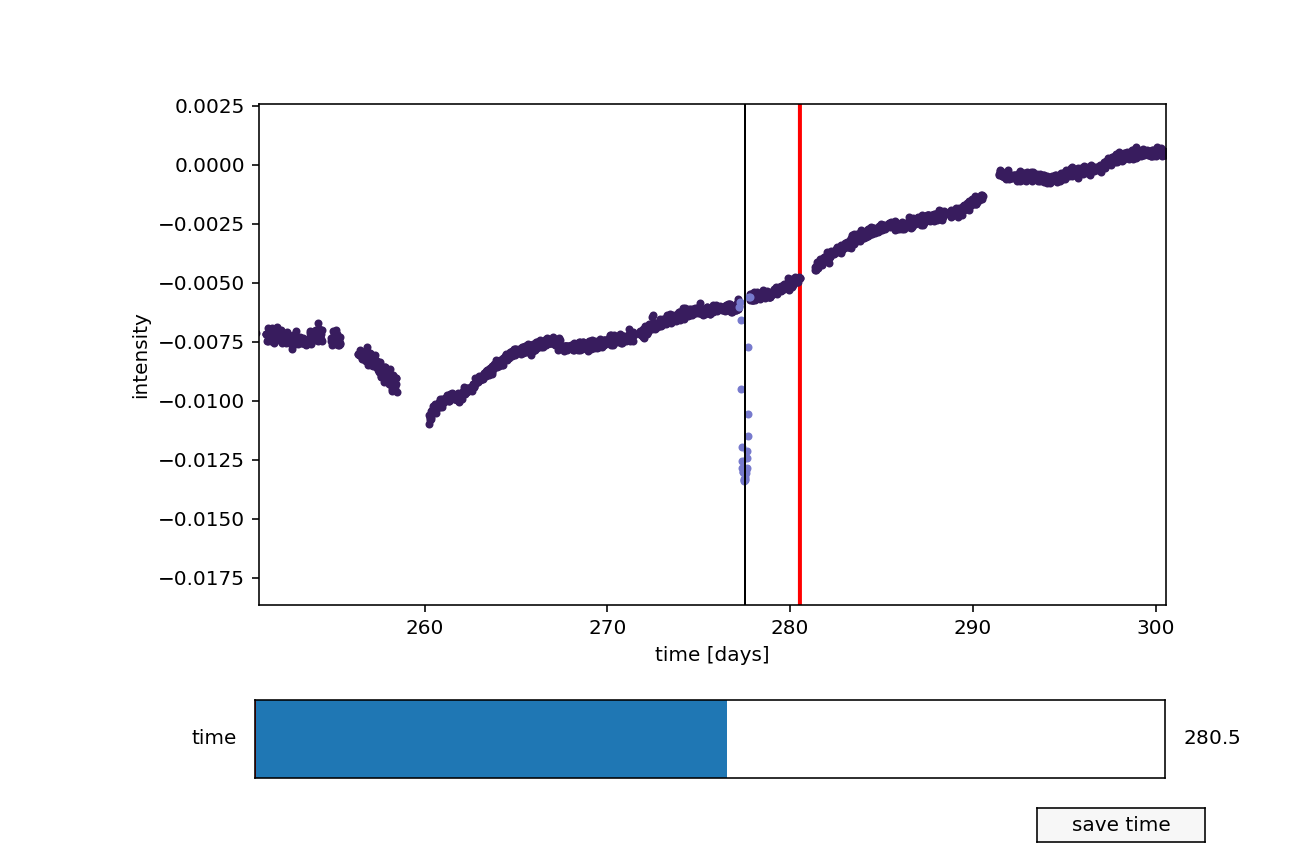

<IPython.core.display.Javascript object>


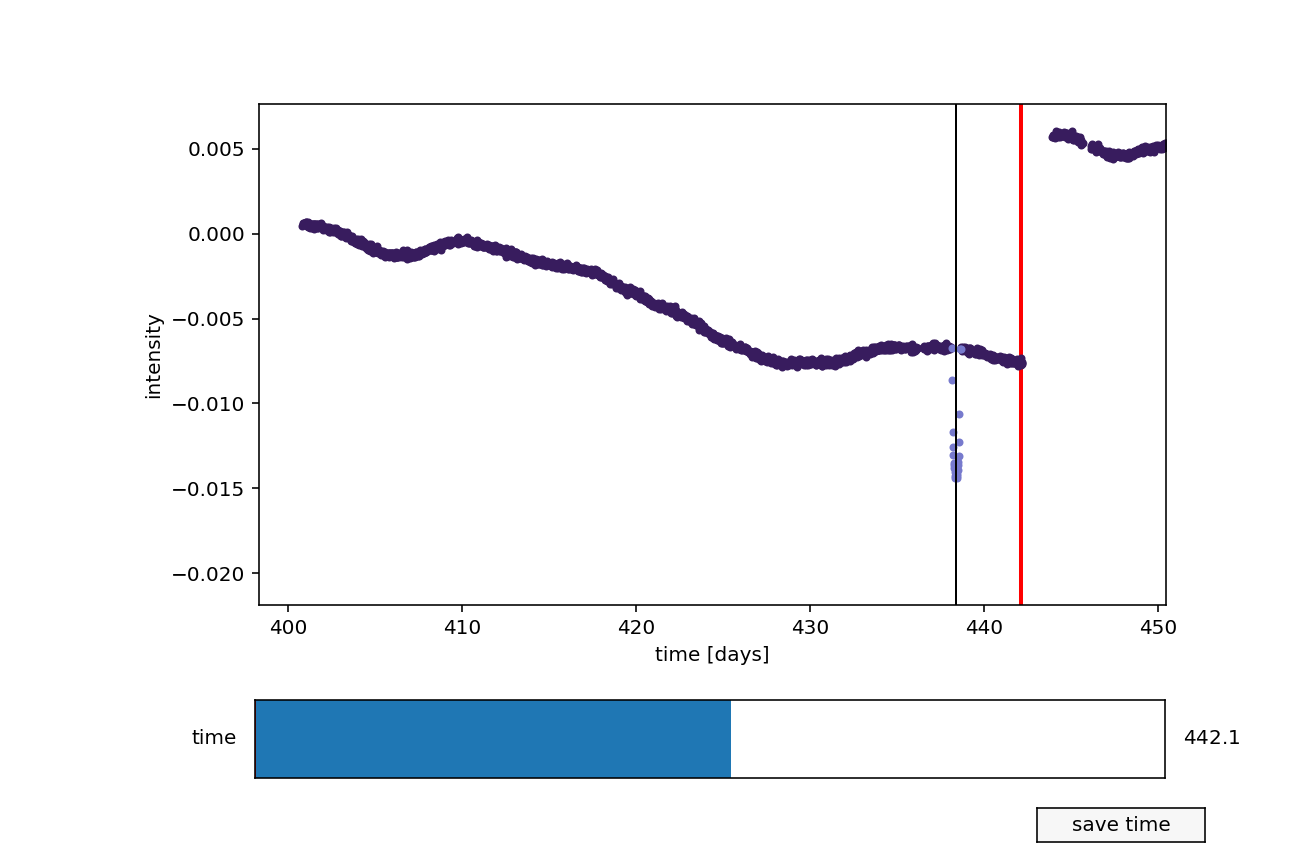

<IPython.core.display.Javascript object>


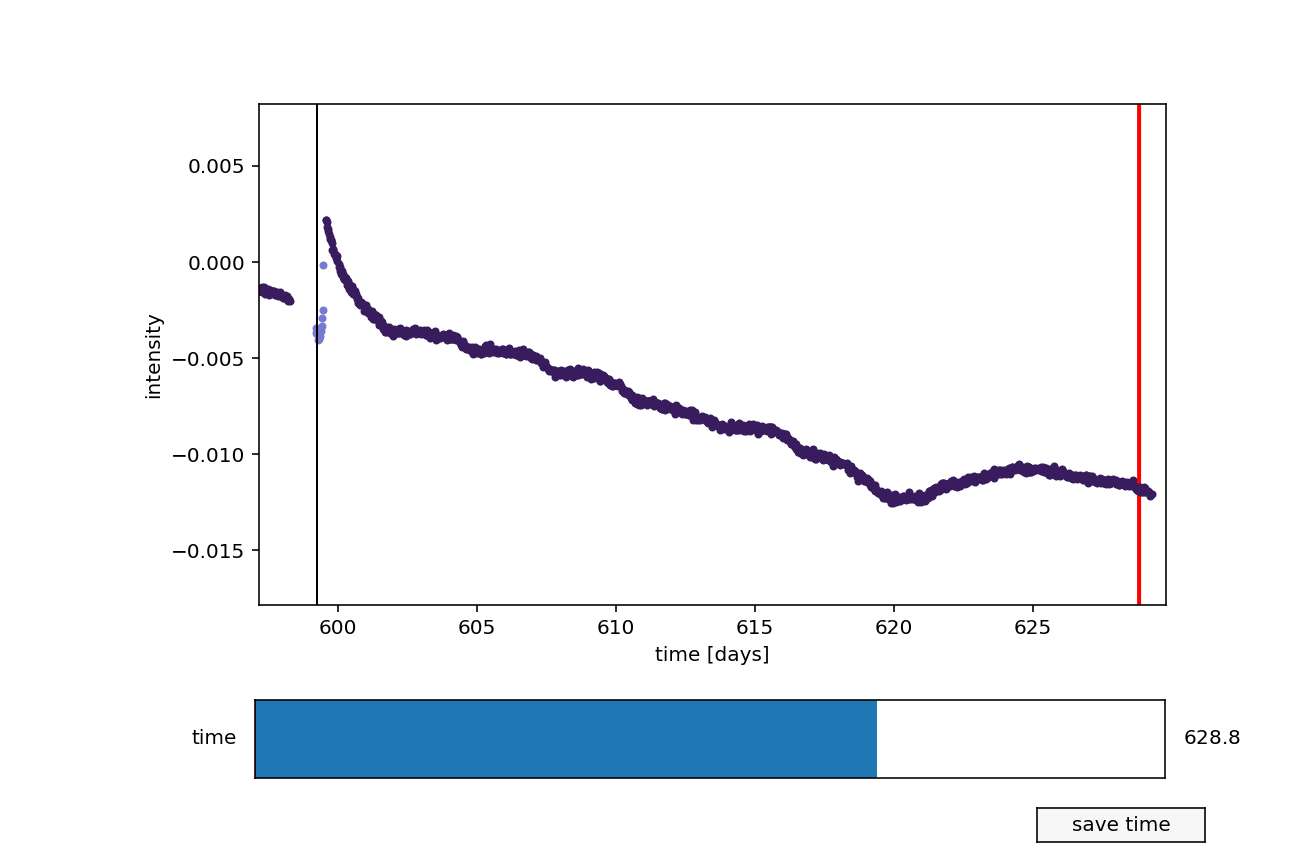

<IPython.core.display.Javascript object>


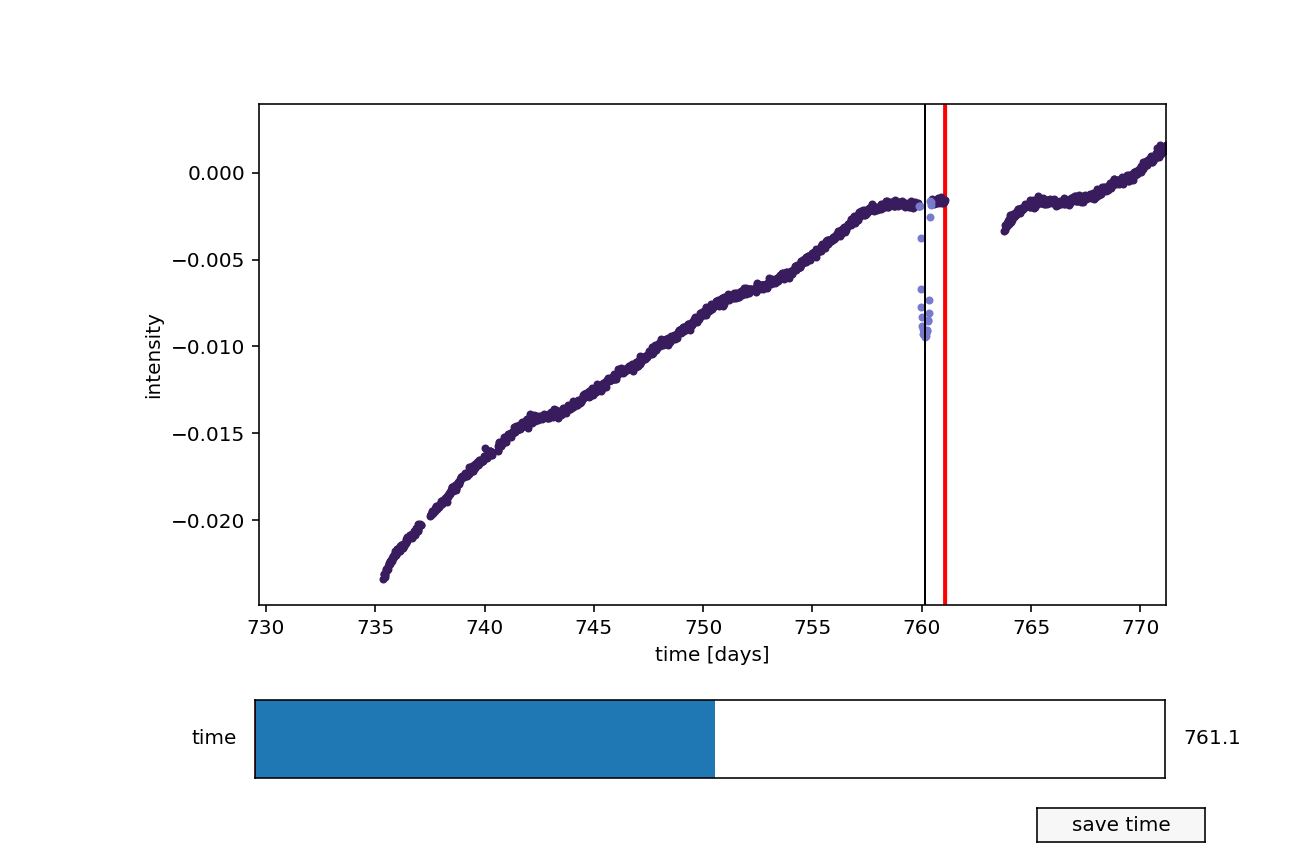

<IPython.core.display.Javascript object>


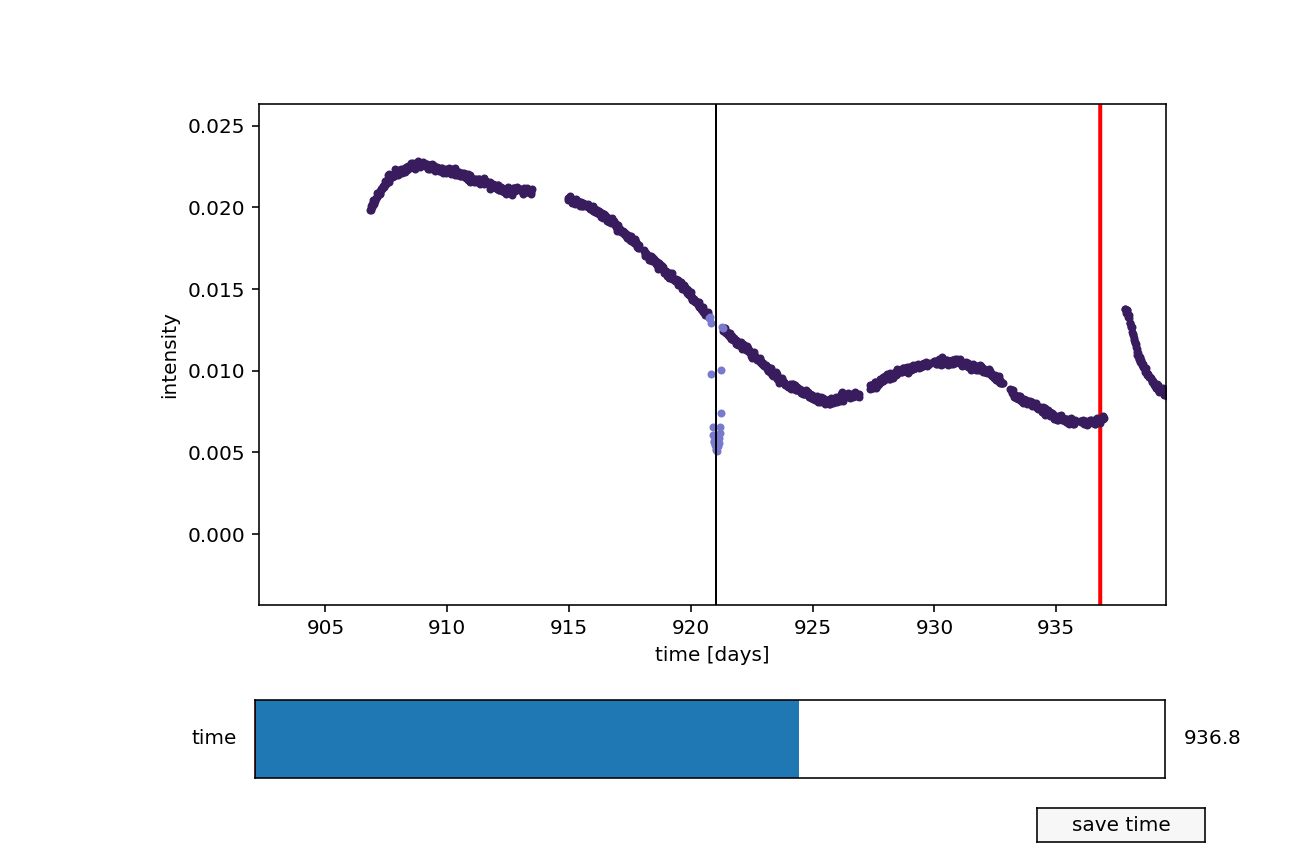

<IPython.core.display.Javascript object>


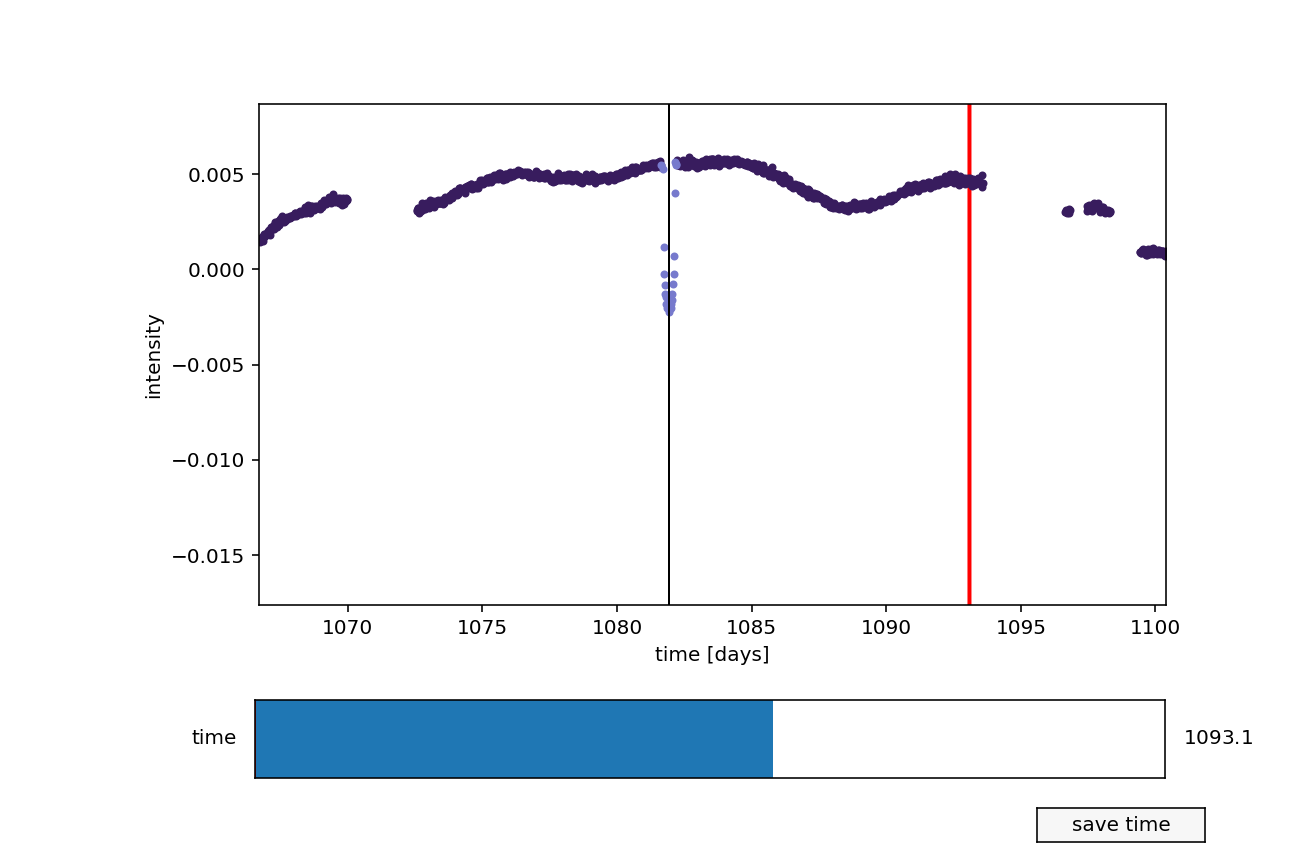

<IPython.core.display.Javascript object>


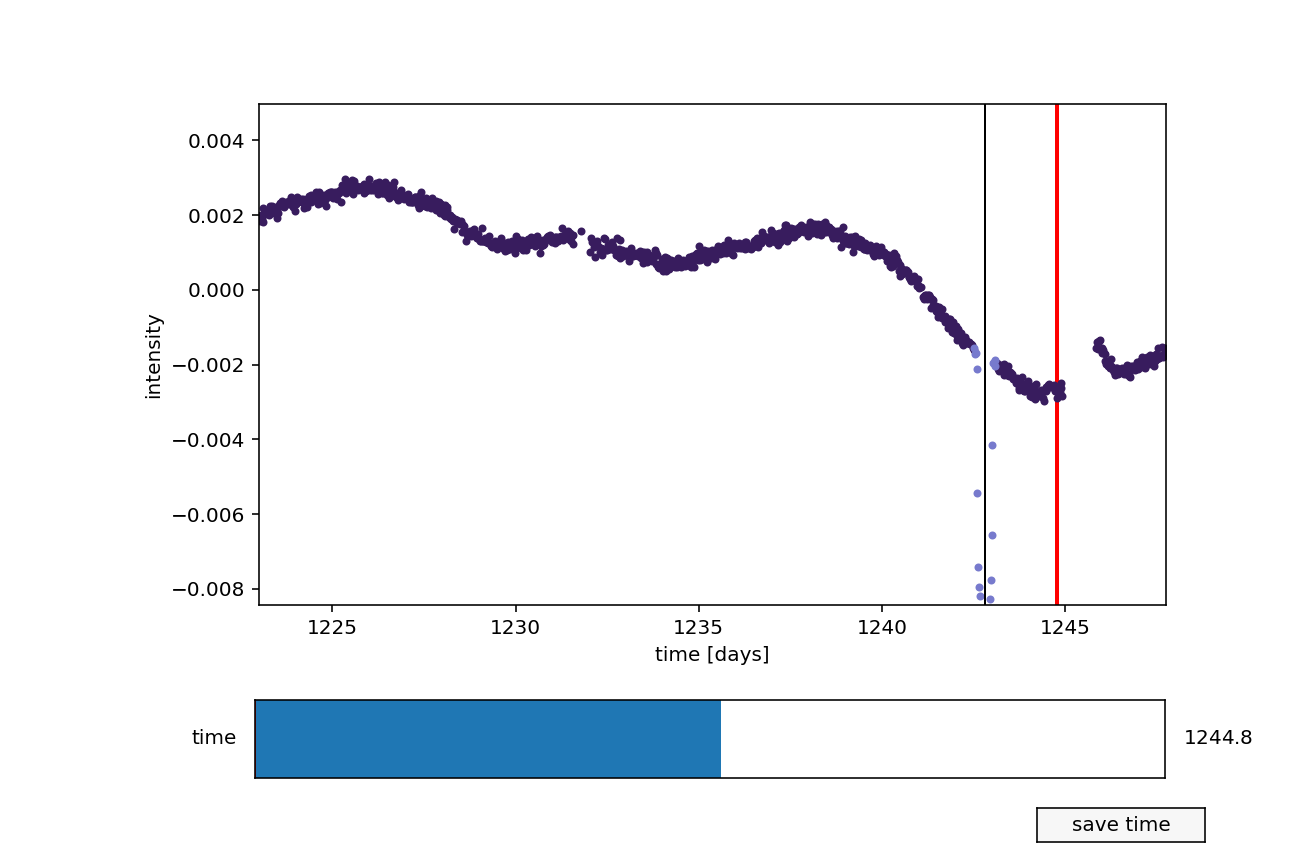

<IPython.core.display.Javascript object>


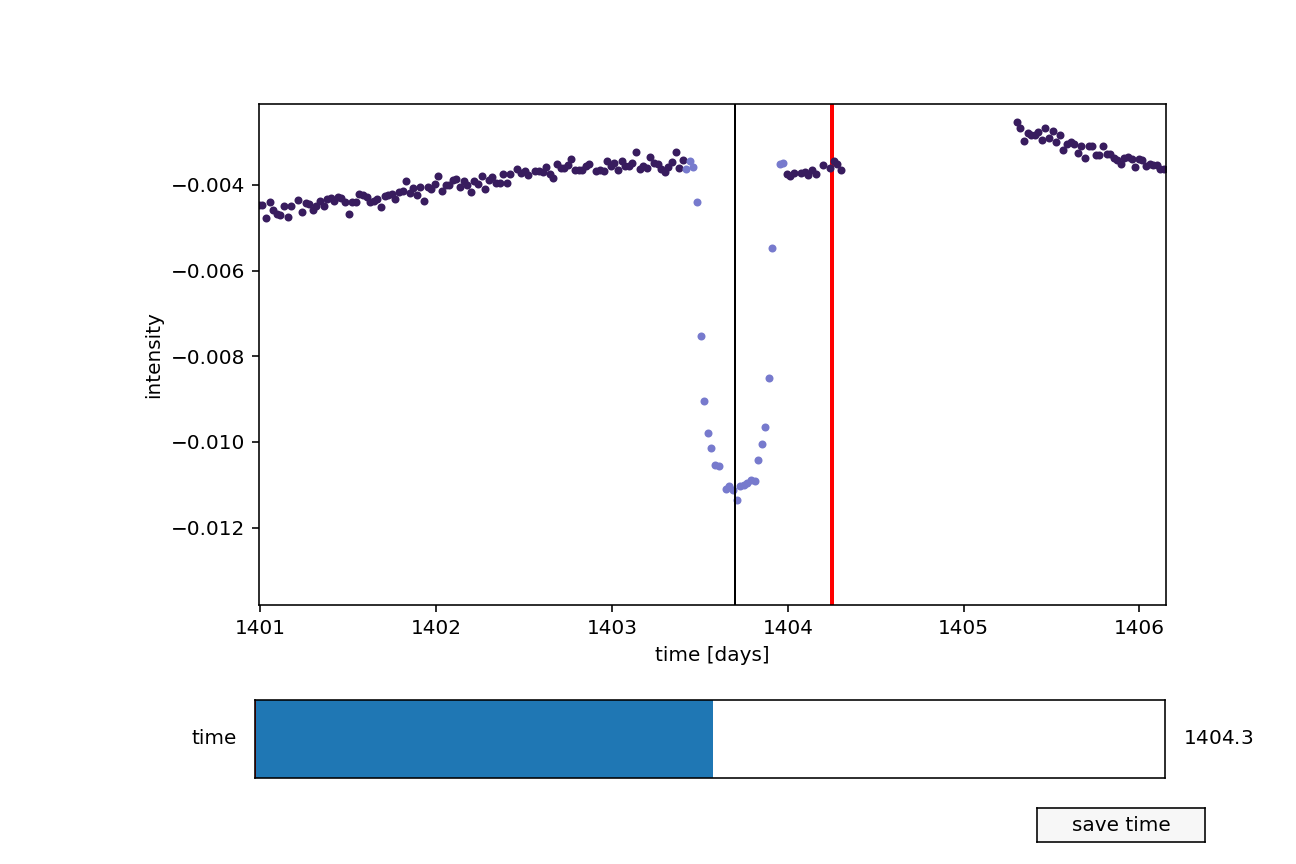

<IPython.core.display.Javascript object>


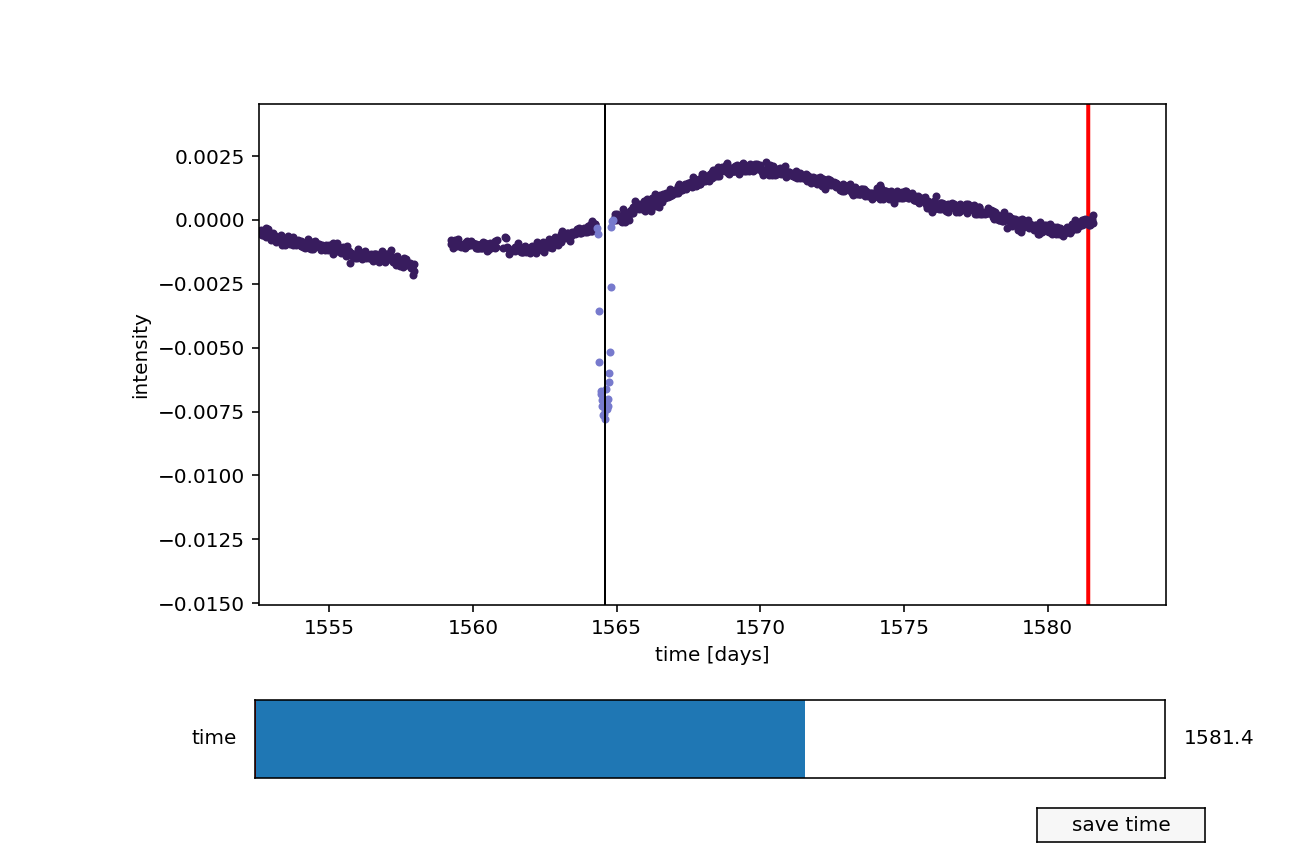

([<matplotlib.widgets.Slider at 0x16f86ffd0>,
  <matplotlib.widgets.Button at 0x16f3e6f70>])

In [24]:
%matplotlib notebook

plot_transits(time_star, lc_star, time_transit, lc_transit, t0s, period)




In [25]:
print(problem_times)

[268.155743395954, 280.5343151584008, 401.80753638857107, 442.1263129862549, 599.1205555880572, 628.8291278179295, 735.9554098910177, 761.0662268948383, 908.1576120866835, 936.8051638797747, 1073.286344703808, 1093.0920595237228, 1188.9007902711458, 1244.78119994162, 1373.8352377081853, 1404.2511568959117, 1559.830705582006, 1581.404787796556]


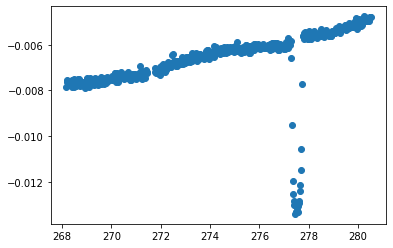

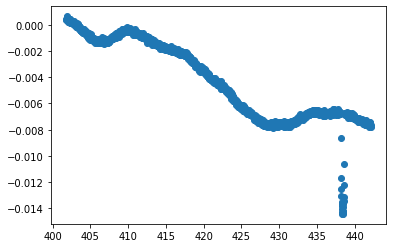

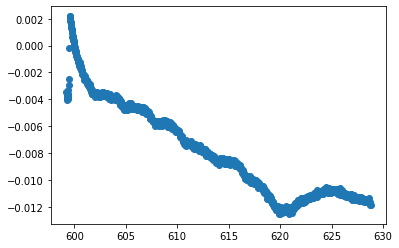

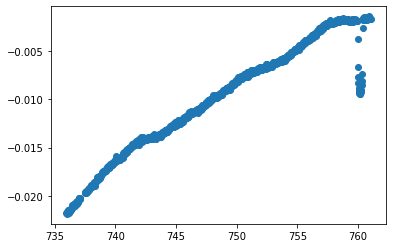

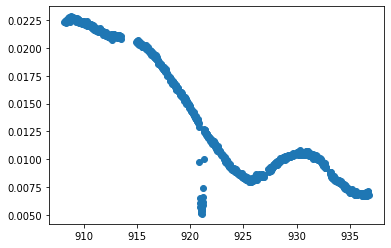

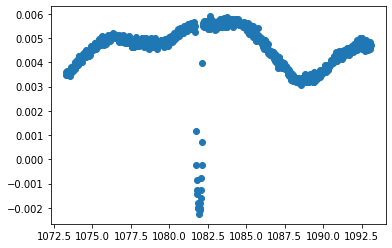

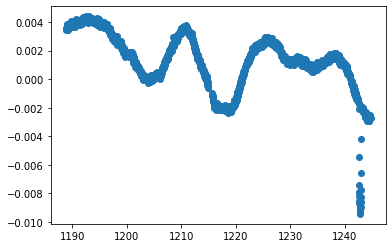

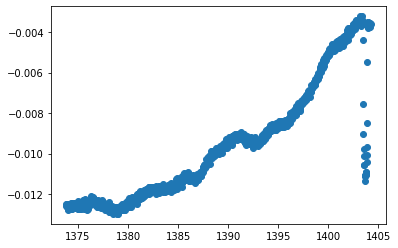

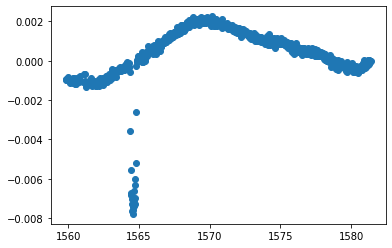

In [26]:
%matplotlib inline

x_epochs, y_epochs, yerr_epochs, mask_epochs = trim_jump_times(x, y, yerr, mask, t0s, period, problem_times)

for ii in range(0, len(x_epochs)):
    plt.plot(x_epochs[ii], y_epochs[ii], 'o')
    plt.show()

In [27]:
def find_problem_times(x, y, t0s, duration):
    problem_times = []
    for ii in range(1, len(y)):
        flux_i = y[ii]
        flux_j = y[ii-1]
        
        

        if np.abs(flux_i - flux_j) > 0.002:


            time_in_transit = False
            for transit in t0s:

                if np.abs(x[ii]-transit) < (2.*duration/24.):
                     time_in_transit = True

            if not time_in_transit:
                problem_times.append(x[ii])
                
    return problem_times


In [28]:
def split_around_problems(x, y, yerr, mask, problem_times):
    problem_split_x = []
    problem_split_y = []
    problem_split_yerr = []
    problem_split_mask = []

    split_x = []
    split_y = []
    split_yerr = []
    split_mask = []
    
    if problem_times == []:
        output = [np.array([x]), 
                  np.array([y]), 
                  np.array([yerr]), 
                  np.array([mask])]
        
        return output
    
    for ii in range(0, len(x)):
        time = x[ii]
        flux = y[ii]
        flux_err = yerr[ii]
        a_mask = mask[ii]


        #print(time)
        #print(problem_times)
        #print(np.isclose(time, np.array(problem_times)))
        bad_time = find_nearest(x, time)
        if time not in x:
            print('uh oh')
        if bad_time in problem_times:

            problem_split_x.append(np.array(split_x))
            problem_split_y.append(np.array(split_y))
            problem_split_yerr.append(np.array(split_yerr))
            problem_split_mask.append(np.array(split_mask))

            split_x = []
            split_y = []
            split_yerr = []
            split_mask = []


        split_x.append(time)
        split_y.append(flux)
        split_yerr.append(flux_err)
        split_mask.append(a_mask)
        
    
    
    
    
    output = [np.array(problem_split_x), 
              np.array(problem_split_y), 
              np.array(problem_split_yerr), 
              np.array(problem_split_mask)]
    return output

In [29]:
def split_data_gaps(x, y, yerr, mask, trouble_times, transit_times):
    '''
    input:
    x = array of times with data gaps around transit
    y = array of fluxes with data gaps around transit
    yerr = array of flux errors with data gaps around transit
    mask = array of transit mask with data gaps around transit
    trouble_times = array of times where there are data gaps
    transit_times = array of times of transits
    
    NOTE: can only split data once per input data as currently constructed
    
    return:
    x_out = array of times without data gaps around transit
    y_out = array of fluxs without data gaps around transit
    yerr_out = array of flux errors without data gaps around transit
    mask = array of transit mask without data gaps around transit
    
    '''
    
    split_data = False
    for trouble_time in trouble_times:
        for ii in range(1, len(x)):
            time_i = x[ii]
            time_i_minus1 = x[ii-1]

            if time_i > trouble_time and time_i_minus1 < trouble_time:
                x_left = x[0:ii]
                y_left = y[0:ii]
                yerr_left = yerr[0:ii]
                mask_left = mask[0:ii]

                x_right = x[ii:len(x)]
                y_right = y[ii:len(y)]
                yerr_right = yerr[ii:len(yerr)]
                mask_right = mask[ii:len(mask)]
                
                
                if split_data:
                    print("ERROR, 2 DATA SPLITS IN INPUT DATA!!")
                split_data = True
            
    
    
    if split_data:
        
        use_left = False
        for transit_time in transit_times:

            if np.abs(find_nearest(x_left, transit_time)-transit_time) < .1:
                use_left = True

            
        if use_left:
            x_out = x_left
            y_out = y_left
            yerr_out = yerr_left
            mask_out = mask_left
            
        else:
            x_out = x_right
            y_out = y_right
            yerr_out = yerr_right
            mask_out = mask_right

    else:
        x_out = x
        y_out = y
        yerr_out = y
        mask_out = mask
        
    return x_out, y_out, yerr_out, mask_out

In [30]:
def plot_problem_times(xs_star, ys_star, xs_transit, ys_transit, t0s_in_data, window, period, problem_times):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxed in transit
    #t0s_in_data = midtransits in data
    #window = what fraction of the period to plot on either side of transit (ie. window=1/2 means 1/2 period on either side)
    #period = planet period to define plotting limit
    #problem_times = picked "problem_times" from find_problem_times based on flux jump criteria
    


    fig = plt.figure()
    cid = fig.canvas.mpl_connect('button_press_event', mouse_event)
    
    _, ax = plt.subplots(nrows = len(problem_times), figsize = [6,3*len(problem_times)])
    if len(problem_times) > 1:
        for ii in range(0, len(problem_times)):
            problem_time = problem_times[ii]
            
            if ii > 0:
                xmin = problem_times[ii-1]
            else:
                xmin = np.min(xs_star)
            
            if ii < len(problem_times)-1:
                xmax = problem_times[ii+1]
            else:
                xmax = np.max(xs_star)
                
            ax[ii].plot(xs_star, ys_star, '.', color = '#381c5e', alpha = 0.5)
            ax[ii].plot(xs_transit, ys_transit, '.', color = '#777acd', alpha = 0.5)
            [ax[ii].axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
            [ax[ii].axvline(_x, linewidth=1, color='r') for _x in problem_times]
            ax[ii].set_xlabel("time [days]")
            ax[ii].set_ylabel("intensity")
            ax[ii].set_xlim(xmin, xmax)
        
    else:
        xmin,xmax = np.min(xs_star), np.max(xs_star)
        
        ax.plot(xs_star, ys_star, '.', color = '#381c5e')
        ax.plot(xs_transit, ys_transit, '.', color = '#777acd')
        [ax.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
        [ax[ii].axvline(_x, linewidth=1, color='r') for _x in problem_times]
        ax.set_xlabel("time [days]")
        ax.set_ylabel("intensity")
        ax[ii].set_xlim(xmin, xmax)
        
    fig.tight_layout()
    fig.show()
    
    return None

In [31]:
def mouse_move(event):
    x, y = event.xdata, event.ydata
    print(x, y)

In [32]:
def modify_problem_times(times, prob_times, a_prob_time, not_a_prob_time):
    import bisect 
    target_size = len(prob_times)+len(a_prob_time)-len(not_a_prob_time)

    problem_times = prob_times.copy()
    for time in not_a_prob_time:
        bad_time = find_nearest(problem_times, time)
        if np.abs(bad_time - time) > 1:
            print("ERROR, DIDN'T FIND PROBLEM TIME WITHIN 1 DAY OF INPUT")
        problem_times.remove(bad_time)

    for time in a_prob_time:
        if time not in problem_times:
            bisect.insort(problem_times, find_nearest(times, time))
        
    if target_size != len(problem_times):
        print("ERROR, PROBLEM TIMES LENGTHS DON'T MATCH")
    return problem_times
        
                

In [33]:
### Special thanks to Michael Hippke for speeding this function up by orders of magnitude!
#@jit(fastmath=True, nopython=True, cache=True)
#@jit
#@jit((float64[:], i8))

def BIC(model, data, errors, nparams):
    chi2 = np.nansum(((model - data) / errors)**2)
    BICval = nparams*np.log(len(data)) + chi2
    return BICval

def polyAM_matrix_gen(times, degree):
    baseline = np.nanmax(times) - np.nanmin(times)
    rows = len(times)
    #cols = 2 * (degree+1) #### this was the CoFiAM formulation 
    cols = (degree+1) #### if degree = 2, you need three columns -- for ax^2 + bx^1 + cx^0
    X_matrix = np.ones(shape=(rows,cols))
    for x in range(rows): ### for each row, that is, for each time!
        for y in range(1, int(cols/2)): #### for each column, up to half the columns -- why?
            #sinarg = (2*np.pi*times[x] * y) / baseline
            #X_matrix[x,y*2] = np.sin(sinarg)
            #X_matrix[x,y*2 + 1] = np.cos(sinarg)
            X_matrix[x,y*2] = times[x]**y #### TRY THIS!
        X_matrix[x,1] = times[x]
    return X_matrix 


def polyAM_matrix_coeffs(times, fluxes, degree):
    assert len(times) > 0
    Xmat = polyAM_matrix_gen(times, degree)
    beta_coefs = np.linalg.lstsq(Xmat, fluxes, rcond=None)[0]
    return Xmat, beta_coefs

### this function spits out the best fit line!
def polyAM_function(times, fluxes, degree):
    input_times = times.astype('f8')
    input_fluxes = fluxes.astype('f8')
    polyAM_matrix, polyAM_coefficients = polyAM_matrix_coeffs(input_times, input_fluxes, degree)
    output = np.matmul(polyAM_matrix, polyAM_coefficients)
    return output 



def polyLOC_matrix_gen(times, degree):
    baseline = np.nanmax(times) - np.nanmin(times)
    rows = len(times)
    #cols = 2 * (degree+1) #### this was the CoFiAM formulation 
    cols = (degree+1) #### if degree = 2, you need three columns -- for ax^2 + bx^1 + cx^0
    X_matrix = np.ones(shape=(rows,cols))
    for x in range(rows): ### for each row, that is, for each time!
        for y in range(1, int(cols/2)): #### for each column, up to half the columns -- why?
            #sinarg = (2*np.pi*times[x] * y) / baseline
            #X_matrix[x,y*2] = np.sin(sinarg)
            #X_matrix[x,y*2 + 1] = np.cos(sinarg)
            X_matrix[x,y*2] = times[x]**y #### TRY THIS!
        X_matrix[x,1] = times[x]
    return X_matrix 


def polyLOC_matrix_coeffs(times, fluxes, degree):
    assert len(times) > 0
    Xmat = polyLOC_matrix_gen(times, degree)
    beta_coefs = np.linalg.lstsq(Xmat, fluxes, rcond=None)[0]
    return Xmat, beta_coefs



### this function spits out the best fit line!
def polyLOC_function(times, fluxes, degree):
    input_times = times.astype('f8')
    input_fluxes = fluxes.astype('f8')
    polyLOC_matrix, polyLOC_coefficients = polyLOC_matrix_coeffs(input_times, input_fluxes, degree)
    output = np.matmul(polyLOC_matrix, polyLOC_coefficients)
    return output 


def polyLOC_iterative(times, fluxes, errors, mask, max_degree=30, min_degree=1):
    ### this function utilizes polyAM_function above, iterates it up to max_degree.
    ### max degree may be calculated using max_order function

    vals_to_min = []
    degs_to_try = np.arange(min_degree,max_degree+1,1)
    BICstats = []

    for deg in degs_to_try:
        output_function = polyAM_function(times[~mask], fluxes[~mask], deg) ### this is the model
        residuals = fluxes[~mask] - output_function
        BICstat = BIC(output_function, fluxes[~mask], errors[~mask], deg+1)
        BICstats.append(BICstat)

    BICstats = np.array(BICstats)

    best_degree = degs_to_try[np.argmin(BICstats)]
    best_BIC = BICstats[np.argmin(np.array(BICstats))]

    ### re-generate the function with the best degree

    best_model = polyLOC_function(times[~mask], fluxes[~mask], best_degree)

    return best_model, best_degree, best_BIC, max_degree 



In [34]:
def local_method(x, y, yerr, mask, t0s, duration, period):
    x_split, y_split, yerr_split, mask_split = split_around_transits(x, y, yerr, mask, t0s, float(6*duration/(24.))/period, period)

    x_no_data_gaps = []
    y_no_data_gaps = []
    yerr_no_data_gaps = []
    mask_no_data_gaps = []

    local_mod = []
    local_mod_all = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []
    for ii in range(0, len(x_split)):
        x_i = np.array(x_split[ii])
        y_i = np.array(y_split[ii])
        yerr_i = np.array(yerr_split[ii])
        mask_i = np.array(mask_split[ii])

        x_ii, y_ii, yerr_ii, mask_ii = split_data_gaps(x_i, y_i, yerr_i, mask_i, [599, 1405], t0s)
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
        

        local = polyLOC_iterative(x_ii, y_ii, yerr_ii, mask_ii)


        polyLOC_interp = interp1d(x_ii[~mask_ii], local[0], bounds_error=False, fill_value='extrapolate')
        best_model = polyLOC_interp(x_ii)
        
        local_mod.append(best_model)
        local_mod_all.extend(best_model)
        
        
    sap_x, sap_y, sap_yerr = recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star)

    return np.array(x_all), np.array(y_all), np.array(yerr_all), np.array(mask_all), np.array(local_mod_all)





In [35]:
def DurbinWatson(residuals):
    residual_terms = []
    for nres, res in enumerate(residuals):
        try:
            residual_terms.append(residuals[nres+1] - residuals[nres])
        except:
            pass
    residual_terms = np.array(residual_terms)
    numerator = np.sum(residual_terms**2)
    denominator = np.sum(residuals**2)
    return numerator / denominator


def polyAM_matrix_gen(times, degree):
    baseline = np.nanmax(times) - np.nanmin(times)
    rows = len(times)
    cols = (degree+1) #### if degree = 2, you need 3 columns (including x^0 term)
    X_matrix = np.ones(shape=(rows,cols))
    for x in range(rows): ### for each time
        for y in range(1, int(cols/2)): #### for each column, up to half the columns -- why?
            X_matrix[x,y*2] = times[x]**y #### TRY THIS!
        X_matrix[x,1] = times[x]
    return X_matrix 


def polyAM_matrix_coeffs(times, fluxes, degree):
    assert len(times) > 0
    Xmat = polyAM_matrix_gen(times, degree)
    beta_coefs = np.linalg.lstsq(Xmat, fluxes, rcond=None)[0]
    return Xmat, beta_coefs



### this function spits out the best fit line!
def polyAM_function(times, fluxes, degree):
    input_times = times.astype('f8')
    input_fluxes = fluxes.astype('f8')
    polyAM_matrix, polyAM_coefficients = polyAM_matrix_coeffs(input_times, input_fluxes, degree)
    output = np.matmul(polyAM_matrix, polyAM_coefficients)
    return output 


def polyAM_iterative(times, fluxes, mask, max_degree=20, min_degree=1):
    ### this function utilizes polyAM_function above, iterates it up to max_degree.

    vals_to_minimize = []
    degs_to_try = np.arange(min_degree, max_degree+1,1)
    DWstats = []

    for deg in degs_to_try:
        output_function = polyAM_function(times[~mask], fluxes[~mask], deg)

        residuals = fluxes[~mask] - output_function

        DWstat = DurbinWatson(residuals)
        DWstats.append(DWstat)

        val_to_minimize = (DWstat - 2)**2
        vals_to_minimize.append(val_to_minimize)

    best_degree = degs_to_try[np.argmin(np.array(vals_to_minimize))]
    best_DW = DWstats[np.argmin(np.array(vals_to_minimize))]

    ### re-generate the function with the best degree

    best_model = polyAM_function(times[~mask], fluxes[~mask], best_degree)

    return best_model, best_degree, best_DW, max_degree 


In [36]:
def polynomial_method(x, y, yerr, mask, t0s, duration, period):
    
    
    

    poly_mod = []
    poly_mod_all = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []

    for ii in range(0, len(x)):
        x_ii = x[ii]
        y_ii = y[ii]
        yerr_ii = yerr[ii]
        mask_ii = mask[ii]
        
        
        
        poly = polyAM_iterative(x_ii, y_ii, mask_ii, max_degree=30)

        
        poly_interp = interp1d(x_ii[~mask_ii], poly[0], bounds_error=False, fill_value='extrapolate')
        best_model = poly_interp(x_ii)
        
        '''
        plt.plot(x_ii, y_ii, 'o', color ='k')
        plt.plot(x_ii, best_model, 'o', color ='b')
        [plt.axvline(_x, linewidth=1, color='r') for _x in problem_times]
        plt.xlim(np.min(x_ii)-5,np.max(x_ii)+5) 

        plt.show()

        plt.plot(x_ii, (y_ii+1)/(best_model+1)-1, 'o', color ='k')
        plt.xlim(np.min(x_ii)-5,np.max(x_ii)+5) 
        plt.show()
        '''
        
        poly_mod.append(best_model)
        poly_mod_all.extend(best_model)
        
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
    
    x_out, y_out, yerr_out, mask_out, model_out = split_around_transits(np.array(x_all), 
                                                                        np.array(y_all), 
                                                                        np.array(yerr_all), 
                                                                        np.array(mask_all), 
                                                                        t0s, float(6*duration/(24.))/period, 
                                                                        period, model=np.array(poly_mod_all))
    
    x_out = np.concatenate(x_out, axis=0)
    y_out = np.concatenate(y_out, axis=0)
    yerr_out = np.concatenate(yerr_out, axis=0)
    mask_out = np.concatenate(mask_out, axis=0)
    model_out = np.concatenate(model_out, axis=0)
    
    return x_out, y_out, yerr_out, mask_out, model_out




In [37]:
"""
we need to solve the problem
AX = B
where A is a vector of coefficients for our linear problem
X is a matrix of terms, multiplying those values by the coefficients in A will give us
B the function values.
NOTE THAT THE COFIAM ALGORITHM FITS TERMS AS FOLLOWS
offset + (amp_s1 * (sin(2pi * time * 1) / (2 * baseline)) + amp_c1 * (cos(2*pi*time * 1) / 2*baseline) + ... up to the degree in question.
NOW FOR THE MATRIX REPRESENTATION, YOU NEED TO DO THIS FOR EVERY TIMESTEP! The matrix rows are for each time in your array!
"""

def max_order(times, duration, baseline=0, kmaximum=30):
    if baseline == 0:
        baseline = np.nanmax(times) - np.nanmin(times)
    assert duration > 0
    kmax = int((2*baseline) / (12*duration))
    if kmax > kmaximum:
        kmax = kmaximum
    if kmax == 0:
        kmax = 1
    return kmax 



def DurbinWatson(residuals):
    residual_terms = []
    for nres, res in enumerate(residuals):
        try:
            residual_terms.append(residuals[nres+1] - residuals[nres])
        except:
            pass
    residual_terms = np.array(residual_terms)
    numerator = np.nansum(residual_terms**2)
    denominator = np.nansum(residuals**2)
    assert denominator != 0.
    return numerator / denominator



def cofiam_matrix_gen(times, degree):
    baseline = np.nanmax(times) - np.nanmin(times)
    assert baseline > 0
    rows = len(times)
    cols = 2 * (degree+1)
    X_matrix = np.ones(shape=(rows,cols))
    for x in range(rows):
        for y in range(1, int(cols/2)):
            sinarg = (2*np.pi*times[x] * y) / baseline
            X_matrix[x,y*2] = np.sin(sinarg)
            X_matrix[x,y*2 + 1] = np.cos(sinarg)
        X_matrix[x,1] = times[x]
    return X_matrix 


def cofiam_matrix_coeffs(times, fluxes, degree):
    assert len(times) > 0
    Xmat = cofiam_matrix_gen(times, degree)
    beta_coefs = np.linalg.lstsq(Xmat, fluxes, rcond=None)[0]
    return Xmat, beta_coefs



### this function spits out the best fit line!
def cofiam_function(times, fluxes, degree):
    input_times = times.astype('f8')
    input_fluxes = fluxes.astype('f8')
    cofiam_matrix, cofiam_coefficients = cofiam_matrix_coeffs(input_times, input_fluxes, degree)
    output = np.matmul(cofiam_matrix, cofiam_coefficients)
    return output 


def cofiam_iterative(times, fluxes, mask, max_degree=30, min_degree=1):
    ### this function utilizes cofiam_function above, iterates it up to max_degree.
    ### max degree may be calculated using max_order function

    vals_to_min = []
    degs_to_try = np.arange(min_degree,max_degree+1,1)
    DWstats = []

    for deg in degs_to_try:
        #print("k = ", deg)
        output_function = cofiam_function(times[~mask], fluxes[~mask], deg)

        residuals = fluxes[~mask] - output_function

        DWstat = DurbinWatson(residuals)
        DWstats.append(DWstat)

        val_to_minimize = (DWstat - 2)**2
        vals_to_min.append(val_to_minimize)

    best_degree = degs_to_try[np.argmin(np.array(vals_to_min))]
    best_DW = DWstats[np.argmin(np.array(vals_to_min))]
    
    ### re-generate the function with the best degree

    best_model = cofiam_function(times[~mask], fluxes[~mask], best_degree)

    return best_model, best_degree, best_DW, max_degree



In [38]:
def cofiam_method(x, y, yerr, mask, t0s, duration, period):
    
    
    

    cofiam_mod = []
    cofiam_mod_all = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []

    for ii in range(0, len(x)):
        x_ii = x[ii]
        y_ii = y[ii]
        yerr_ii = yerr[ii]
        mask_ii = mask[ii]
        
        
        
        cofiam = cofiam_iterative(x_ii, y_ii, mask_ii, max_degree=30)

        
        cofiam_interp = interp1d(x_ii[~mask_ii], cofiam[0], bounds_error=False, fill_value='extrapolate')
        best_model = cofiam_interp(x_ii)
        
        '''
        plt.plot(x_ii, y_ii, 'o', color ='k')
        plt.plot(x_ii, best_model, 'o', color ='b')
        [plt.axvline(_x, linewidth=1, color='r') for _x in problem_times]
        plt.xlim(np.min(x_ii)-5,np.max(x_ii)+5) 

        plt.show()

        plt.plot(x_ii, (y_ii+1)/(best_model+1)-1, 'o', color ='k')
        plt.xlim(np.min(x_ii)-5,np.max(x_ii)+5) 
        plt.show()
        '''
        
        cofiam_mod.append(best_model)
        cofiam_mod_all.extend(best_model)
        
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
    
    x_out, y_out, yerr_out, mask_out, model_out = split_around_transits(np.array(x_all), 
                                                                        np.array(y_all), 
                                                                        np.array(yerr_all), 
                                                                        np.array(mask_all), 
                                                                        t0s, float(6*duration/(24.))/period, 
                                                                        period, model=np.array(cofiam_mod_all))
    
    x_out = np.concatenate(x_out, axis=0)
    y_out = np.concatenate(y_out, axis=0)
    yerr_out = np.concatenate(yerr_out, axis=0)
    mask_out = np.concatenate(mask_out, axis=0)
    model_out = np.concatenate(model_out, axis=0)
    
    return x_out, y_out, yerr_out, mask_out, model_out

In [39]:
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet as xo
import aesara_theano_fallback.tensor as tt
from functools import partial
from celerite2.theano import terms, GaussianProcess

In [40]:
def gp_new(time_star, lc_star, lc_err_star, time_model):



    # Find a reference transit time near the middle of the observations to avoid
    # strong covariances between period and t0
    #x_min = min(np.min(x) for x, _, _, _ in datasets.values())
    #x_max = max(np.max(x) for x, _, _, _ in datasets.values())
    #x_mid = 0.5 * (x_min + x_max)
    #t0_ref = lit_t0 + lit_period * np.round((x_mid - lit_t0) / lit_period)

    with pm.Model() as model:
        
        rho_gp = pm.InverseGamma(
            "rho_gp",
            testval=2.0,
            **pmx.estimate_inverse_gamma_parameters(1.0, 5.0),
        )

        
        with pm.Model() as model:
            # The flux zero point
            mean = pm.Normal("mean", mu=0.0, sigma=10.0)

            
            # Noise parameters
            med_yerr = np.median(lc_err_star)
            std_y = np.std(lc_star)
            
            
            print('here')
            print('std_y', 0.5 * std_y)
            print('med_yerr', med_yerr)
            print('')
            print('')
            print('')
            print('')
            
            
            sigma_gp = pm.InverseGamma(
                "sigma_gp",
                testval=0.5 * std_y,
                **pmx.estimate_inverse_gamma_parameters(
                    med_yerr, std_y
                ),
            )



        # The Gaussian Process noise model
        kernel = terms.SHOTerm(sigma=sigma_gp, rho=rho_gp, Q=1.0 / 3)
        gp = GaussianProcess(
            kernel, t=time_star, diag=lc_err_star ** 2, mean=mean
        )
        gp.marginal("gp", observed=lc_star)
        
        # Compute the GP model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict(lc_star, t=time_model))

        # Optimize the model
        map_soln = model.test_point
        map_soln = pmx.optimize(map_soln)
        
        return map_soln

In [41]:
def gp_method(x, y, yerr, mask, t0s, duration, period):

    gp_mod = []
    gp_mod_all = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []
    for ii in range(0, len(x)):
        x_ii = x[ii]
        y_ii = y[ii]
        yerr_ii = yerr[ii]
        mask_ii = mask[ii]
        

        gp_model = gp_new(x_ii[~mask_ii], y_ii[~mask_ii], yerr_ii[~mask_ii], x_ii)
        
        '''
        logp1 = gp_model1[0].check_test_point(test_point=gp_model1[1]).sum(axis = 0)
        
        
        gp_model2 = gp2(x_ii[~mask_ii], y_ii[~mask_ii], yerr_ii[~mask_ii], x_ii)
        logp2 = gp_model2[0].check_test_point(test_point=gp_model2[1]).sum(axis = 0)
        
        
        if logp1 > logp2:
            gp_model = gp_model1[1]['pred']
            
        else:
            gp_model = gp_model2[1]['pred']
        
        '''
        
        gp_mod.append(gp_model['pred'])
        gp_mod_all.extend(gp_model['pred'])
        
        
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
    
    x_out, y_out, yerr_out, mask_out, model_out = split_around_transits(np.array(x_all), 
                                                                        np.array(y_all), 
                                                                        np.array(yerr_all), 
                                                                        np.array(mask_all), 
                                                                        t0s, float(6*duration/(24.))/period, 
                                                                        period, model=np.array(gp_mod_all))
    
    x_out = np.concatenate(x_out, axis=0)
    y_out = np.concatenate(y_out, axis=0)
    yerr_out = np.concatenate(yerr_out, axis=0)
    mask_out = np.concatenate(mask_out, axis=0)
    model_out = np.concatenate(model_out, axis=0)

        
    return x_out, y_out, yerr_out, mask_out, model_out




In [43]:
#kepler 1513 = koi-3678
time_star, lc_star, lc_err_star, \
time_transit, lc_transit, lc_err_transit, \
t0s, period, duration, mask = get_light_curve('koi-3678', 'sap_flux', Kepler=True)

sap_x, sap_y, sap_yerr = recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star)
x_epochs, y_epochs, yerr_epochs, mask_epochs = trim_jump_times(sap_x, sap_y, sap_yerr, mask, t0s, period, problem_times)

x_epochs = np.concatenate(x_epochs, axis=0)
y_epochs = np.concatenate(y_epochs, axis=0)
yerr_epochs = np.concatenate(yerr_epochs, axis=0)
mask_epochs = np.concatenate(mask_epochs, axis=0)

sap_x_all, sap_y_all, sap_yerr_all, sap_mask_all, sap_local_mod = \
local_method(x_epochs, y_epochs, yerr_epochs, mask_epochs, t0s, duration, period)

/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/astropy/table/table.py:3197: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


Exoplanet Archive: Planet Comparison Table
------------------------------------------

            tic_id      t0 [BJD]  period [days]  duration [hours]
921  TIC 394177315  2.455111e+06     160.884651           10.7536
[ 268.17324934  268.19368209  268.21411495 ... 1581.3360517  1581.35648624
 1581.37692078]


<ipython-input-16-55b1547d8f77>:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x_split), np.array(y_split), np.array(yerr_split), np.array(mask_split)


In [44]:
#kepler 1513 = koi-3678
time_star, lc_star, lc_err_star, \
time_transit, lc_transit, lc_err_transit, \
t0s, period, duration, mask = get_light_curve('koi-3678', 'pdcsap_flux', Kepler=True)

pdcsap_x, pdcsap_y, pdcsap_yerr = recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star)
x_epochs, y_epochs, yerr_epochs, mask_epochs = trim_jump_times(pdcsap_x, pdcsap_y, pdcsap_yerr, mask, t0s, period, problem_times)

x_epochs = np.concatenate(x_epochs, axis=0)
y_epochs = np.concatenate(y_epochs, axis=0)
yerr_epochs = np.concatenate(yerr_epochs, axis=0)
mask_epochs = np.concatenate(mask_epochs, axis=0)

pdcsap_x_all, pdcsap_y_all, pdcsap_yerr_all, pdcsap_mask_all, pdcsap_local_mod = \
local_method(x_epochs, y_epochs, yerr_epochs, mask_epochs, t0s, duration, period)

/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/astropy/table/table.py:3197: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


Exoplanet Archive: Planet Comparison Table
------------------------------------------

            tic_id      t0 [BJD]  period [days]  duration [hours]
921  TIC 394177315  2.455111e+06     160.884651           10.7536
[ 268.17324934  268.19368209  268.21411495 ... 1581.3360517  1581.35648624
 1581.37692078]


<ipython-input-16-55b1547d8f77>:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x_split), np.array(y_split), np.array(yerr_split), np.array(mask_split)


In [45]:
def remove_trim_times(x, y, yerr, trim_times):
    
    for trim in trim_times:
        trim_min = find_nearest(x, trim[0]) 
        trim_max = find_nearest(x, trim[1]) 
        
        index_min = int(np.where(x == trim_min)[0])
        index_max = int(np.where(x == trim_max)[0])
        
        indices = np.arange(index_min, index_max)

        
        x = np.delete(x, indices)
        y = np.delete(y, indices)
        yerr = np.delete(yerr, indices)
        
    return x, y, yerr


In [46]:
#kepler 1513 = koi-3678
%matplotlib inline

time_star, lc_star, lc_err_star, \
time_transit, lc_transit, lc_err_transit, \
t0s, period, duration, mask = get_light_curve('koi-3678', 'sap_flux', Kepler=True)


sap_x, sap_y, sap_yerr = recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star)
x_epochs, y_epochs, yerr_epochs, mask_epochs = trim_jump_times(sap_x, sap_y, sap_yerr, mask, t0s, period, problem_times)


print('here:')
print(x_epochs)
sap_x_all, sap_y_all, sap_yerr_all, sap_mask_all, sap_poly_mod = \
polynomial_method(x_epochs, y_epochs, yerr_epochs, mask_epochs, t0s, duration, period)

/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/astropy/table/table.py:3197: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


Exoplanet Archive: Planet Comparison Table
------------------------------------------

            tic_id      t0 [BJD]  period [days]  duration [hours]
921  TIC 394177315  2.455111e+06     160.884651           10.7536
here:
[array([268.17324934, 268.19368209, 268.21411495, 268.23454761,
       268.27541322, 268.29584587, 268.31627863, 268.33671148,
       268.35714424, 268.37757689, 268.39800965, 268.4184424 ,
       268.43887515, 268.45930791, 268.47974066, 268.50017341,
       268.52060607, 268.54103882, 268.56147167, 268.58190442,
       268.60233708, 268.62276993, 268.64320268, 268.66363533,
       268.68406808, 268.72493359, 268.74536634, 268.76579919,
       268.78623184, 268.80666459, 268.82709744, 268.84753009,
       268.86796284, 268.88839559, 268.90882844, 268.92926109,
       268.97012668, 269.01099208, 269.03142473, 269.05185758,
       269.07229032, 269.09272307, 269.11315582, 269.13358857,
       269.15402131, 269.17445396, 269.19488681, 269.21531955,
       269.2357522

[ 268.17324934  268.19368209  268.21411495 ... 1581.3360517  1581.35648624
 1581.37692078]


<ipython-input-16-55b1547d8f77>:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x_split), np.array(y_split), np.array(yerr_split), np.array(mask_split),  np.array(model_split)


In [47]:
#kepler 1513 = koi-3678
time_star, lc_star, lc_err_star, \
time_transit, lc_transit, lc_err_transit, \
t0s, period, duration, mask = get_light_curve('koi-3678', 'pdcsap_flux', Kepler=True)

pdcsap_x, pdcsap_y, pdcsap_yerr = recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star)
x_epochs, y_epochs, yerr_epochs, mask_epochs = trim_jump_times(pdcsap_x, pdcsap_y, pdcsap_yerr, mask, t0s, period, problem_times)

pdcsap_x_all, pdcsap_y_all, pdcsap_yerr_all, pdcsap_mask_all, pdcsap_poly_mod = \
polynomial_method(x_epochs, y_epochs, yerr_epochs, mask_epochs, t0s, duration, period)

/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/astropy/table/table.py:3197: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


Exoplanet Archive: Planet Comparison Table
------------------------------------------

            tic_id      t0 [BJD]  period [days]  duration [hours]
921  TIC 394177315  2.455111e+06     160.884651           10.7536
[ 268.17324934  268.19368209  268.21411495 ... 1581.3360517  1581.35648624
 1581.37692078]


<ipython-input-16-55b1547d8f77>:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x_split), np.array(y_split), np.array(yerr_split), np.array(mask_split),  np.array(model_split)


In [48]:
#kepler 1513 = koi-3678
time_star, lc_star, lc_err_star, \
time_transit, lc_transit, lc_err_transit, \
t0s, period, duration, mask = get_light_curve('koi-3678', 'sap_flux', Kepler=True)

sap_x, sap_y, sap_yerr = recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star)
x_epochs, y_epochs, yerr_epochs, mask_epochs = trim_jump_times(sap_x, sap_y, sap_yerr, mask, t0s, period, problem_times)

sap_x_all, sap_y_all, sap_yerr_all, sap_mask_all, sap_cofiam_mod = \
cofiam_method(x_epochs, y_epochs, yerr_epochs, mask_epochs, t0s, duration, period)

/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/astropy/table/table.py:3197: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


Exoplanet Archive: Planet Comparison Table
------------------------------------------

            tic_id      t0 [BJD]  period [days]  duration [hours]
921  TIC 394177315  2.455111e+06     160.884651           10.7536
[ 268.17324934  268.19368209  268.21411495 ... 1581.3360517  1581.35648624
 1581.37692078]


<ipython-input-16-55b1547d8f77>:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x_split), np.array(y_split), np.array(yerr_split), np.array(mask_split),  np.array(model_split)


In [49]:
#kepler 1513 = koi-3678
time_star, lc_star, lc_err_star, \
time_transit, lc_transit, lc_err_transit, \
t0s, period, duration, mask = get_light_curve('koi-3678', 'pdcsap_flux', Kepler=True)

pdcsap_x, pdcsap_y, pdcsap_yerr = recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star)
x_epochs, y_epochs, yerr_epochs, mask_epochs = trim_jump_times(pdcsap_x, pdcsap_y, pdcsap_yerr, mask, t0s, period, problem_times)

pdcsap_x_all, pdcsap_y_all, pdcsap_yerr_all, pdcsap_mask_all, pdcsap_cofiam_mod = \
cofiam_method(x_epochs, y_epochs, yerr_epochs, mask_epochs, t0s, duration, period)

/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/astropy/table/table.py:3197: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


Exoplanet Archive: Planet Comparison Table
------------------------------------------

            tic_id      t0 [BJD]  period [days]  duration [hours]
921  TIC 394177315  2.455111e+06     160.884651           10.7536
[ 268.17324934  268.19368209  268.21411495 ... 1581.3360517  1581.35648624
 1581.37692078]


<ipython-input-16-55b1547d8f77>:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x_split), np.array(y_split), np.array(yerr_split), np.array(mask_split),  np.array(model_split)


In [50]:
#kepler 1513 = koi-3678
time_star, lc_star, lc_err_star, \
time_transit, lc_transit, lc_err_transit, \
t0s, period, duration, mask = get_light_curve('koi-3678', 'pdcsap_flux', Kepler=True)

pdcsap_x, pdcsap_y, pdcsap_yerr = recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star)
x_epochs, y_epochs, yerr_epochs, mask_epochs = trim_jump_times(pdcsap_x, pdcsap_y, pdcsap_yerr, mask, t0s, period, problem_times)

pdcsap_x_all, pdcsap_y_all, pdcsap_yerr_all, pdcsap_mask_all, pdcsap_gp_mod = \
gp_method(x_epochs, y_epochs, yerr_epochs, mask_epochs, t0s, duration, period)

/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/astropy/table/table.py:3197: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


Exoplanet Archive: Planet Comparison Table
------------------------------------------

            tic_id      t0 [BJD]  period [days]  duration [hours]
921  TIC 394177315  2.455111e+06     160.884651           10.7536
here
std_y 0.00013270227645989507
med_yerr 9.607301e-05






WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

here
std_y 0.00026933723711408675
med_yerr 9.5581214e-05






WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

here
std_y 0.00046959935571067035
med_yerr 9.398061e-05






WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

here
std_y 0.0003372039063833654
med_yerr 9.630691e-05






WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

here
std_y 0.0011889113811776042
med_yerr 9.524525e-05






WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

here
std_y 0.00033524344325996935
med_yerr 9.805574e-05






WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

here
std_y 0.0008319888729602098
med_yerr 9.568778e-05






WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

here
std_y 0.00036579903098754585
med_yerr 9.772254e-05






WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

here
std_y 0.00043780182022601366
med_yerr 9.615163e-05






WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

[ 268.17324934  268.19368209  268.21411495 ... 1581.3360517  1581.35648624
 1581.37692078]


message: Desired error not necessarily achieved due to precision loss.
logp: 7123.327309907423 -> 7185.171341848716
<ipython-input-16-55b1547d8f77>:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x_split), np.array(y_split), np.array(yerr_split), np.array(mask_split),  np.array(model_split)


In [51]:
#kepler 1513 = koi-3678
time_star, lc_star, lc_err_star, \
time_transit, lc_transit, lc_err_transit, \
t0s, period, duration, mask = get_light_curve('koi-3678', 'sap_flux', Kepler=True)

sap_x, sap_y, sap_yerr = recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star)
x_epochs, y_epochs, yerr_epochs, mask_epochs = trim_jump_times(sap_x, sap_y, sap_yerr, mask, t0s, period, problem_times)

sap_x_all, sap_y_all, sap_yerr_all, sap_mask_all, sap_gp_mod = \
gp_method(x_epochs, y_epochs, yerr_epochs, mask_epochs, t0s, duration, period)

/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/astropy/table/table.py:3197: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


Exoplanet Archive: Planet Comparison Table
------------------------------------------

            tic_id      t0 [BJD]  period [days]  duration [hours]
921  TIC 394177315  2.455111e+06     160.884651           10.7536
here
std_y 0.00042532497900538146
med_yerr 9.620441e-05






WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

here
std_y 0.0014160118298605084
med_yerr 9.5513926e-05






WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

here
std_y 0.0016890948172658682
med_yerr 9.410426e-05






WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

here
std_y 0.00285971537232399
med_yerr 9.62492e-05






WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

here
std_y 0.002763556083664298
med_yerr 9.558901e-05






WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

here
std_y 0.000350961578078568
med_yerr 9.791803e-05






WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

here
std_y 0.0009022628655657172
med_yerr 9.568842e-05






WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

here
std_y 0.0013963538222014904
med_yerr 9.752361e-05






WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

here
std_y 0.0004850533732678741
med_yerr 9.630065e-05






WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

[ 268.17324934  268.19368209  268.21411495 ... 1581.3360517  1581.35648624
 1581.37692078]


message: Optimization terminated successfully.
logp: 7113.85228261033 -> 7187.7737001536225
<ipython-input-16-55b1547d8f77>:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x_split), np.array(y_split), np.array(yerr_split), np.array(mask_split),  np.array(model_split)


In [52]:
def get_detrended_lc(y, detrending_model):
    '''
    input:
    y = light curve
    detrending model = stellar detrending model evaluated at same time as fluxes
    
    returns:
    detrended_lc = detrended light curve evaluated at same time as fluxes
    
    '''
    detrended_lc = (((y + 1) / (detrending_model + 1)) - 1)
    
    return np.array(detrended_lc)


<ipython-input-15-a83f965be678>:94: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


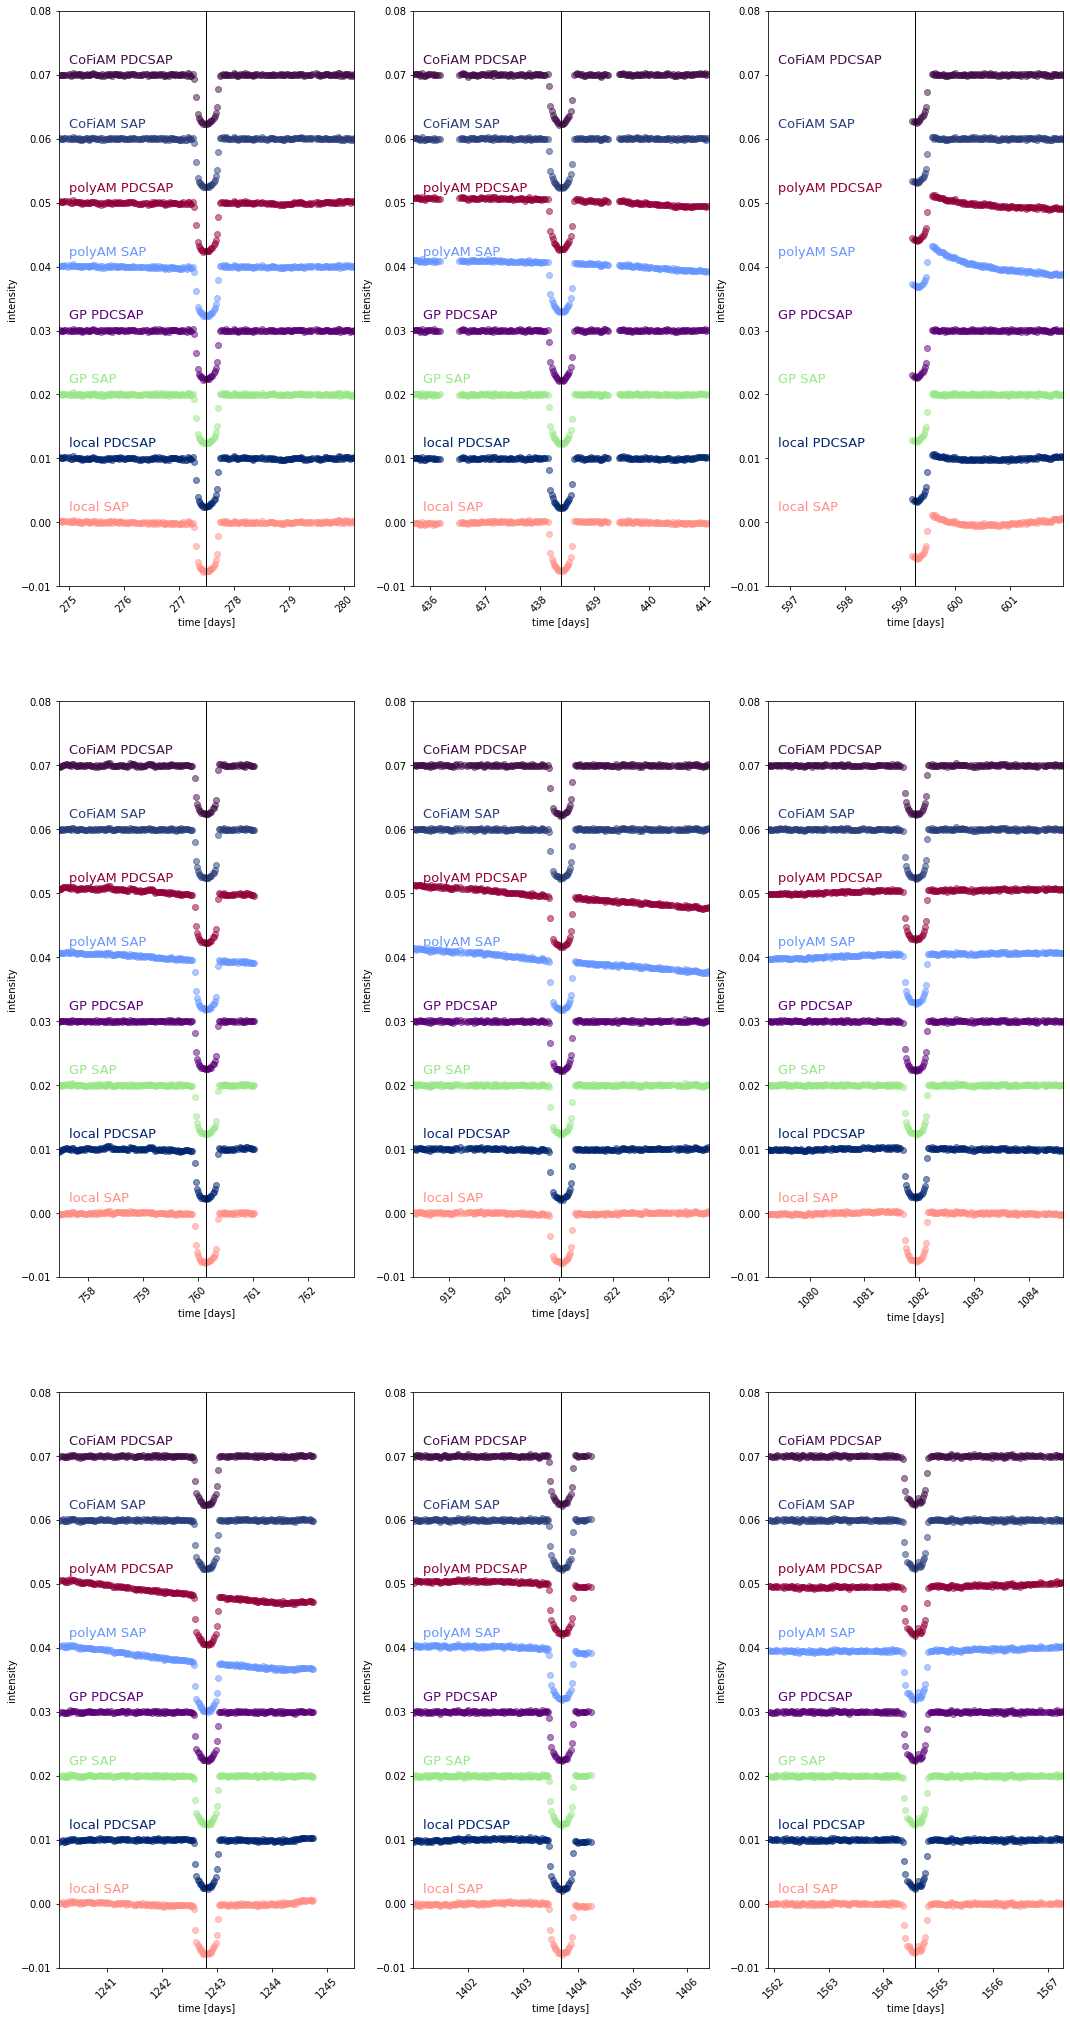

In [53]:
%matplotlib inline
%matplotlib inline

import matplotlib.pyplot as plt


sap_local_detrended = get_detrended_lc(sap_y_all, sap_local_mod)
pdcsap_local_detrended = get_detrended_lc(pdcsap_y_all, pdcsap_local_mod)
sap_gp_detrended = get_detrended_lc(sap_y_all, sap_gp_mod)
pdcsap_gp_detrended = get_detrended_lc(pdcsap_y_all, pdcsap_gp_mod)
sap_poly_detrended = get_detrended_lc(sap_y_all, sap_poly_mod)
pdcsap_poly_detrended = get_detrended_lc(pdcsap_y_all, pdcsap_poly_mod)
sap_cofiam_detrended = get_detrended_lc(sap_y_all, sap_cofiam_mod)
pdcsap_cofiam_detrended = get_detrended_lc(pdcsap_y_all, pdcsap_cofiam_mod)

y_detrended = [sap_local_detrended, pdcsap_local_detrended,
               sap_gp_detrended, pdcsap_gp_detrended,
               sap_poly_detrended, pdcsap_poly_detrended,
               sap_cofiam_detrended, pdcsap_cofiam_detrended]


if sap_x_all.all() == pdcsap_x_all.all():
    x_detrended = sap_x_all
    
if sap_yerr_all.all() == pdcsap_yerr_all.all():
    yerr_detrended = sap_yerr_all
    
if sap_mask_all.all() == pdcsap_mask_all.all():
    mask_detrended = sap_mask_all




plot_detrended_lc(x_detrended, y_detrended,
                  ['local SAP', 'local PDCSAP',
                   'GP SAP', 'GP PDCSAP', 
                   'polyAM SAP', 'polyAM PDCSAP',
                   'CoFiAM SAP', 'CoFiAM PDCSAP'],
                  t0s, float(6*duration/(24.))/period, period,
                  #["#430b4a", "#be4b0b", "#21b0ff", "#b1005f", "#014aa2", "#d974e7"],
                  ["#ff8e85", "#00256f", "#98e787", "#5a0076", "#6695ff", "#930039", "#293d7b", "#420d48"],
                  figname = './figures/koi3678_Jan25_all8.pdf'
)






<ipython-input-15-a83f965be678>:94: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


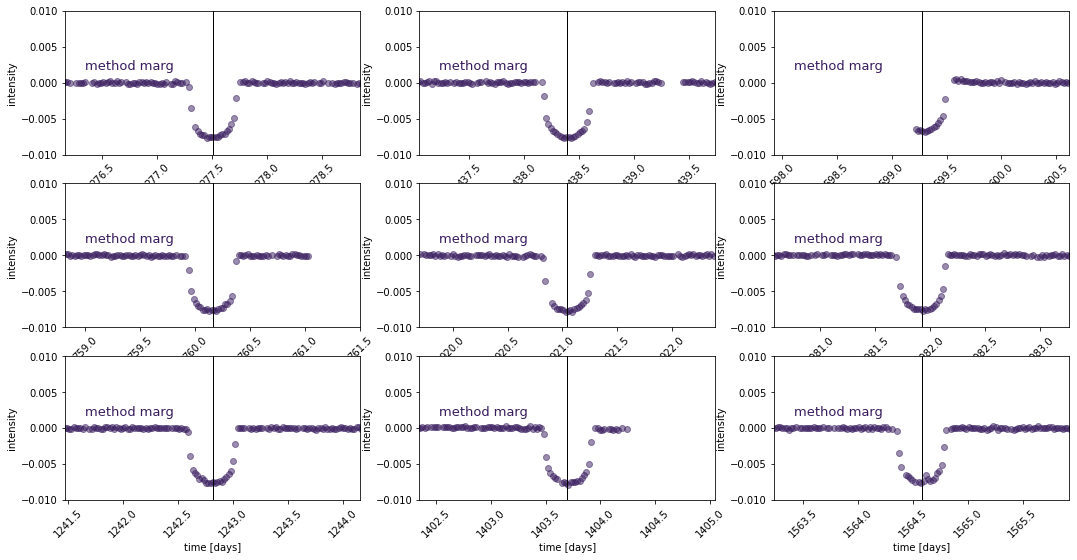

In [54]:
#y_detrended = [sap_local_detrended, pdcsap_local_detrended,
#               sap_gp_detrended, pdcsap_gp_detrended]

y_detrended = np.array(y_detrended)
y_detrended_transpose = y_detrended.T

method_marg_detrended = np.median(y_detrended_transpose, axis=1)

plot_detrended_lc(x_detrended, [method_marg_detrended],
                  ['method marg'],
                  t0s, float(3*duration/(24.))/period, period,
                  ["#381c5e"],
                  figname = './figures/koi3678_method_marg.pdf'
)



In [56]:
x, y, yerr, mask = np.array(x_detrended), np.array(method_marg_detrended), np.array(yerr_detrended), np.array(mask_detrended)


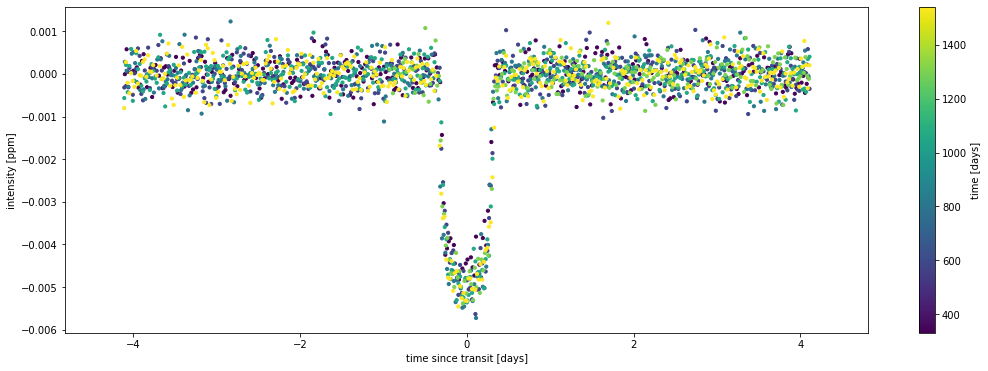

In [505]:
plot_phase_fold_lc(x, y, period, t0s, 50)

## Transit search

Now, let's use [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/timeseries/bls.html)
(Note: you'll need AstroPy v3.1 or more recent to use this feature) to estimate the period, phase, and depth of the transit.

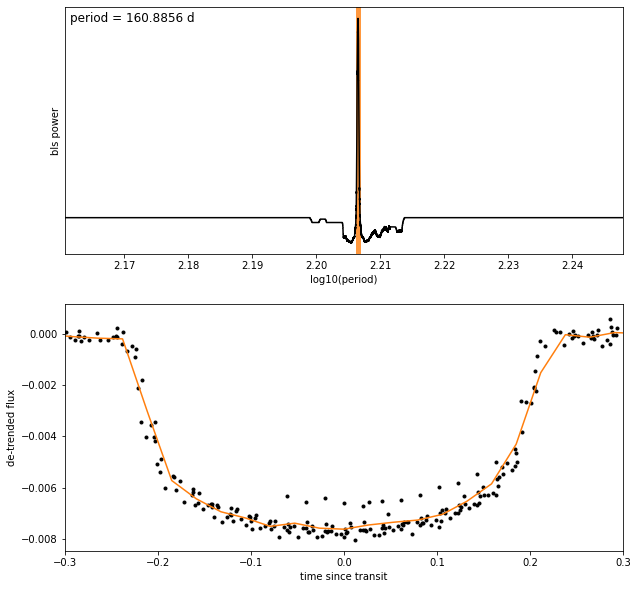

In [392]:

from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(period[0]-.1*period[0]), np.log(period[0]+.1*period[0]), 50000))

bls = BoxLeastSquares(x, y)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (x - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold, y, ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux")
_ = ax.set_xlabel("time since transit")

## The transit model in PyMC3

The transit model, initialization, and sampling are all nearly the same as the one in {ref}`joint`.

In [393]:
texp = 2. / (60.0 * 24.0)


In [394]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt

with pm.Model() as model:

    # This part of the model is similar to the model in the `transit` tutorial
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    u = xo.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    logr = pm.Uniform(
        "logr",
        lower=np.log(0.01),
        upper=np.log(0.1),
        shape=1)
    r = pm.Deterministic("r", tt.exp(logr))
    b = xo.ImpactParameter(
        "b", ror=r, shape=1, testval=0.5 * np.random.rand(1)
    )

    # Now we have a parameter for each transit time for each planet:
    transit_times = []
    for i in range(1):
        transit_times.append(
            pm.Normal(
                "tts_{0}".format(i),
                mu=t0s,
                sd=1.0,
                shape=len(t0s),
            )
        )

    # Set up an orbit for the planets
    orbit = xo.orbits.TTVOrbit(b=b, transit_times=transit_times)

    # It will be useful later to track some parameters of the orbit
    pm.Deterministic("t0", orbit.t0)
    pm.Deterministic("period", orbit.period)
    for i in range(1):
        pm.Deterministic("ttvs_{0}".format(i), orbit.ttvs[i])

    # The rest of this block follows the transit fitting tutorial
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=x, texp=texp
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    pm.Deterministic("light_curves", light_curves)


    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    map_soln = model.test_point
    map_soln = pmx.optimize(start=map_soln, vars=transit_times)
    map_soln = pmx.optimize(start=map_soln, vars=[r, b])
    map_soln = pmx.optimize(start=map_soln, vars=transit_times)
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [tts_0]


/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


message: Desired error not necessarily achieved due to precision loss.
logp: -inf -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [b, logr]


/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


message: Desired error not necessarily achieved due to precision loss.
logp: -inf -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [tts_0]


message: Desired error not necessarily achieved due to precision loss.
logp: -inf -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [tts_0, b, logr, u, mean]


/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


message: Desired error not necessarily achieved due to precision loss.
logp: -inf -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


Here's how we plot the initial light curve model:

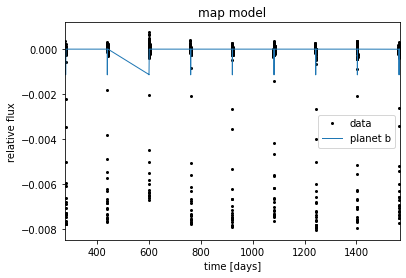

In [395]:
plt.plot(x, y, ".k", ms=4, label="data")
for i, l in enumerate("b"):
    plt.plot(
        x, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(x.min(), x.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

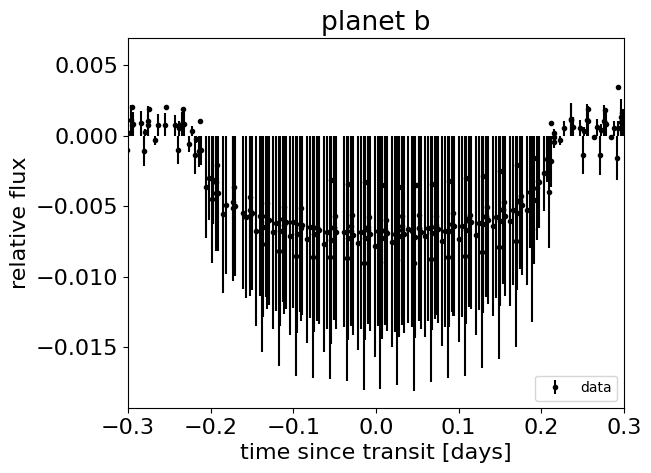

In [77]:
with model:
    t_warp = pmx.eval_in_model(orbit._warp_times(x), map_soln)

for n, letter in enumerate("b"):
    plt.figure()

    p = map_soln["period"][n]

    # NOTE: 't0' has already been subtracted!
    x_fold = (t_warp[:, n] + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, y, yerr=yerr, fmt=".k", label="data", zorder=-1000
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

In [78]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=2,
        chains=2,
        return_inferencedata=True,
    )

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'mean': array(0.), 'u_quadlimbdark__': array([-1.09861229, -0.84729786]), 'logr_interval__': array([-3.88578059e-16]), 'b_impact__': array([-5.12885633]), 'tts_0': array([ 277.504085  ,  438.38873587,  599.27338674,  760.15803761,
        921.04268848, 1081.92733935, 1242.81199022, 1403.69664109,
       1564.58129196]), 'u': array([0.3, 0.2]), 'logr': array([-3.45387764]), 'r': array([0.03162278]), 'b': array([0.00607466]), 't0': array([277.504085]), 'period': array([160.88465087]), 'ttvs_0': array([-4.54747351e-13, -4.54747351e-13, -4.54747351e-13, -4.54747351e-13,
       -4.54747351e-13, -2.27373675e-13, -2.27373675e-13, -2.27373675e-13,
        0.00000000e+00]), 'light_curves': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])}

Initial evaluation results:
mean               -0.92
u_quadlimbdark__   -3.23
logr_interval__    -1.39
b_impact__         -5.14
tts_0              -8.27
obs                 -inf
Name: Log-probability of test_point, dtype: float64

In [70]:
import arviz as az

az.summary(trace, var_names=["mean", "u", "r", "b", "tts_0", "period"])

NameError: name 'trace' is not defined

In [7]:
trace.to_netcdf("my_trace.cdf")

NameError: name 'trace' is not defined

In [67]:
import netCDF4 as nc
fn = 'my_trace.cdf'
ds = nc.Dataset(fn)

In [78]:
import arviz
data = arviz.from_netcdf("my_trace.cdf")
print(data==trace)


True


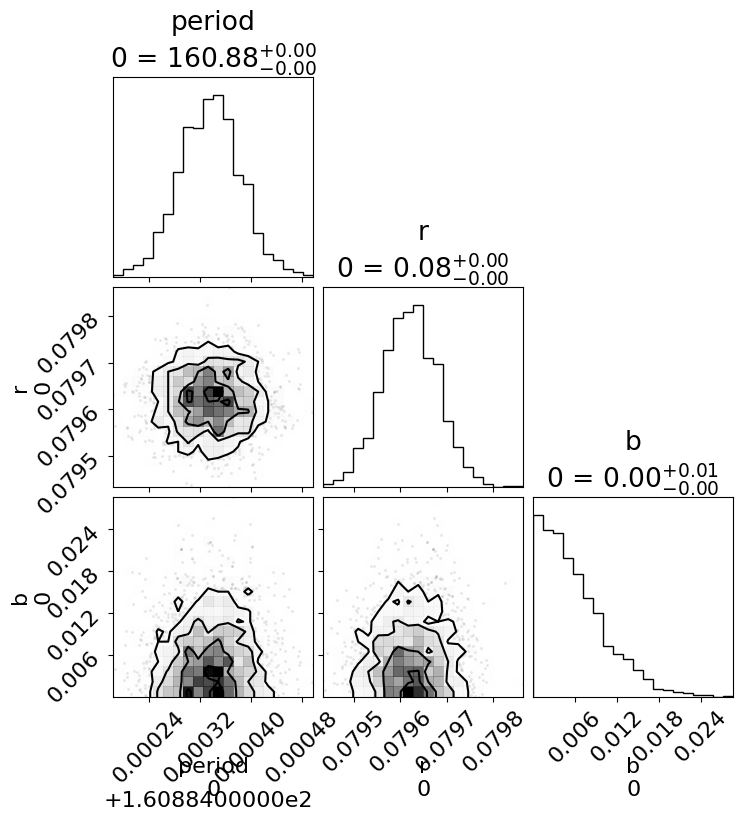

In [1084]:
import corner

names = ["period", "r", "b"]


_ = corner.corner(
    trace,
    var_names=names,
    show_titles=True
)

In [1085]:
tts_median = []
ttvs_median = []
P_median = np.quantile(trace.posterior["period"].values, 0.5)
t0_median = np.median(trace.posterior["t0"].values)

tts_err = []
ttvs_err = []
for ii in range(0, len(t0s)):
    tts = np.median(trace.posterior["tts_0"].values[:, :, ii])
    ttvs = 24.*60.*np.median(trace.posterior["ttvs_0"].values[:, :, ii])
    
    tts_median.append(tts)
    ttvs_median.append(ttvs)
    
    
    tts_quantile = [np.quantile(trace.posterior["tts_0"].values[:, :, ii], 0.16),
                    np.quantile(trace.posterior["tts_0"].values[:, :, ii], 0.84)]
    ttvs_quantile = [24.*60.*np.quantile(trace.posterior["ttvs_0"].values[:, :, ii], 0.16),
                     24.*60.*np.quantile(trace.posterior["ttvs_0"].values[:, :, ii], 0.84)]
    
    tts_err.append(np.array([
        tts - tts_quantile[0],
        tts_quantile[1] - tts
    ]))
    ttvs_err.append(np.array([
        ttvs - ttvs_quantile[0],
        ttvs_quantile[1] - ttvs
    ]))
    

tts_err = np.array(tts_err).T
ttvs_err = np.array(ttvs_err).T



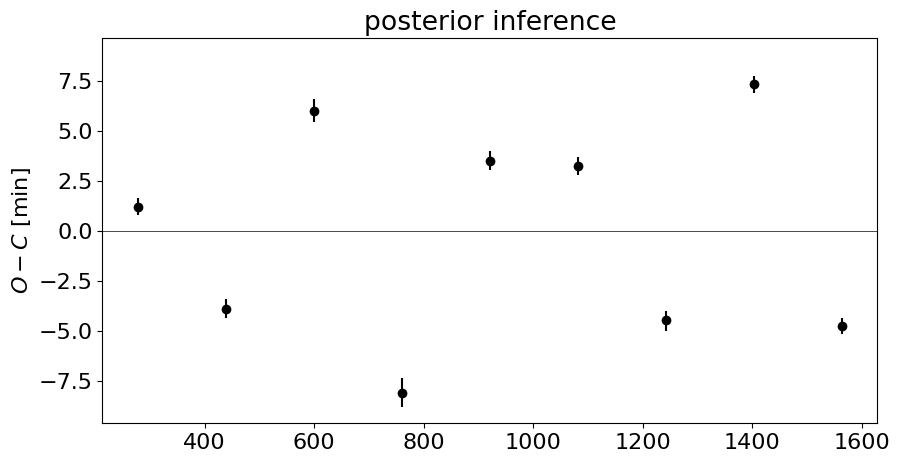

In [1086]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

ax1.errorbar(tts_median, ttvs_median, xerr = tts_err, yerr = ttvs_err, ls = '', marker = 'o', color = 'k')
ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [min]")


_ = ax1.set_title("posterior inference")

1.1994012209015636
1.192966100729791
-3.88683553215742
-3.8925812200022847
6.0010735725700215
6.010413096310003
-8.081732891969295
-8.090191071851223
3.5098909989756066
3.5043075488829345
3.232487173481786
3.2200093410210684
-4.485513308827649
-4.481697274368344
7.31534301150532
7.313608896256483
-4.775686518842122
-4.7739208593156945
277.50630467409303
160.8843361711165

holczer
3.5673493060312467
3.984702898305841
4.81941008269132
5.236763674965914
5.654117267404217
6.071470859678811
6.4888244519534055
6.906178044228

kipping
-0.975626207600726
-4.142474094569479
-1.1673048200646008
-6.7841499898531765
3.045247900645336
2.0617107444559224
-4.794107810521382
7.478927405172726
-4.868453409653739


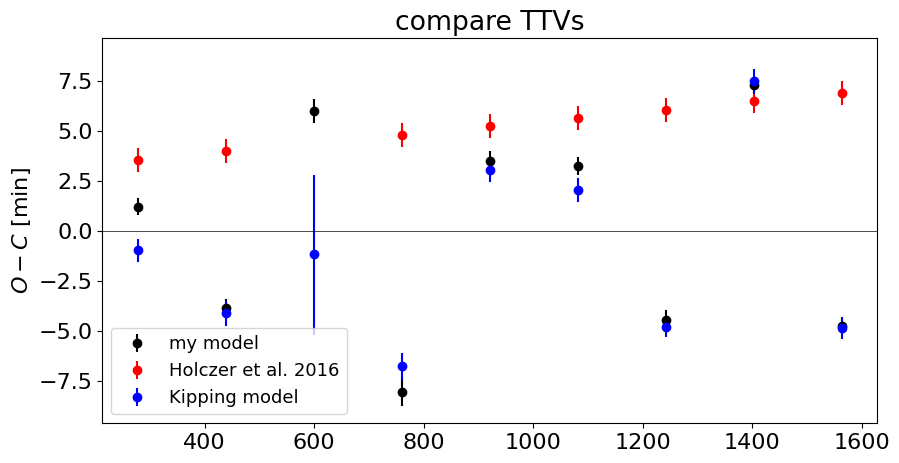

In [1164]:
t_offset = 2454900 - 2454833 

time_model = []
for ii in range(0,9):
    time_model.append(t0_median+(P_median*ii))
    print(24. * 60. * (tts_median[ii]-time_model[ii]))
    print(ttvs_median[ii])
    
print(t0_median)
print(P_median)


    
'''
holczer Vizier data
N	T_i[days]	err[min]
0	210.508782	6e-01
1	371.393408	6e-01
3	693.162660	6e-01
4	854.047286	6e-01
5	1014.931912	6e-01
6	1175.816538	6e-01
7	1336.701164	6e-01
8	1497.585790	6e-01

Period
160.88462604


my period
160.8843361711165

'''
    
print('')
print("holczer")
x_holczer = np.array([210.508782, 371.393408, 693.162660, 854.047286, 1014.931912, 1175.816538, 1336.701164, 1497.585790])
x_holczer += t_offset
y_holczer = []
epoch = 0
for time in x_holczer:
    if epoch == 2:
        epoch += 1
        
    print(24. * 60. * (time-time_model[epoch]))
    y_holczer.append(24. * 60. * (time-time_model[epoch]))
    epoch+=1
    

#y_holczer = np.array([3.6400, -3.6800, -6.0300, 4.5100, 3.0200, -4.2100, 8.1400, -5.3800])
yerr_holczer = np.array([6e-01, 6e-01, 6e-01, 6e-01, 6e-01, 6e-01, 6e-01, 6e-01])

x_kipping = np.array([55110.505627155893, 55271.387764127088, 55432.274166387979,
                      55593.154601972172, 55754.045764114046, 55914.929417273248, 
                      56075.808992459257, 56236.701851571495, 56397.577613172602])
yerr_kipping = np.array([
    [0.000402962774, 0.000399917204],
    [0.000440256757, 0.000441709722],
    [0.002814652733, 0.002745562269],
    [0.00046894051, 0.000469475679],
    [0.000409040716, 0.000403825223],
    [0.000424959595, 0.000417035772],
    [0.000362309329, 0.000367076056],
    [0.000423798963, 0.000430076718],
    [0.000367674438, 0.000366104934]]).T
yerr_kipping = 24.*60.*yerr_kipping

print('')
print("kipping")
x_kipping -= 54833 
y_kipping = []
epoch = 0
for time in x_kipping:
    y_kipping.append(24. * 60. * (time-time_model[epoch]))
    print(24. * 60. * (time-time_model[epoch]))
    epoch+=1
    
'''    
# for TTVs comparison, read in times and then subtract out ephemeris information
0	55110.505627155893	0.000402962774	0.000399917204	1.087096278	0.580266395	0.575880774
1	55271.387764127088	0.000440256757	0.000441709722	-2.265761699	0.633969731	0.636062
2	55432.274166387979	0.002814652733	0.002745562269	0.523397485	4.053099936	3.953609668
3	55593.154601972172	0.00046894051	0.000469475679	-5.279457775	0.675274335	0.676044978
4	55754.045764114046	0.000409040716	0.000403825223	4.363930026	0.589018632	0.581508321
5	55914.929417273248	0.000424959595	0.000417035772	3.194382779	0.611941817	0.600531511
6	56075.808992459257	0.000362309329	0.000367076056	-3.847445866	0.521725434	0.528589521
7	56236.701851571495	0.000423798963	0.000430076718	8.23957926	0.610270507	0.619310473
8	56397.577613172602	0.000367674438	0.000366104934	-4.293811645	0.529451191	0.527191105
'''



fig, ax1 = plt.subplots(1, 1, figsize=(10, 5), sharex=True)


ax1.errorbar(tts_median, ttvs_median, yerr = ttvs_err, ls = '', marker = 'o', color = 'k', label = "my model")
ax1.errorbar(x_holczer, y_holczer, yerr = yerr_holczer, ls = '', marker = 'o', color = 'r', label = "Holczer et al. 2016")
ax1.errorbar(x_kipping, y_kipping, yerr = yerr_kipping, ls = '', marker = 'o', color = 'b', label = "Kipping model")

ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [min]")

ax1.legend(fontsize = 13, loc=3)
_ = ax1.set_title("compare TTVs")             

In [1163]:
plt.plot(x_holczer, x_holczer-[tts_median[0:2]+tts_median[4:]], 'o')

ValueError: operands could not be broadcast together with shapes (8,) (1,7) 


holczer
399612.64608
631286.50752
1094634.2304
1326308.09184
1557981.95328
1789655.8147200001
2021329.67616
2253003.5376

kipping
399608.10310448636
631278.3803430072
862954.7995986894
1094622.6268399274
1326305.9003242257
1557978.360873477
1789644.9491413299
2021330.6662629533
2252991.7629685462


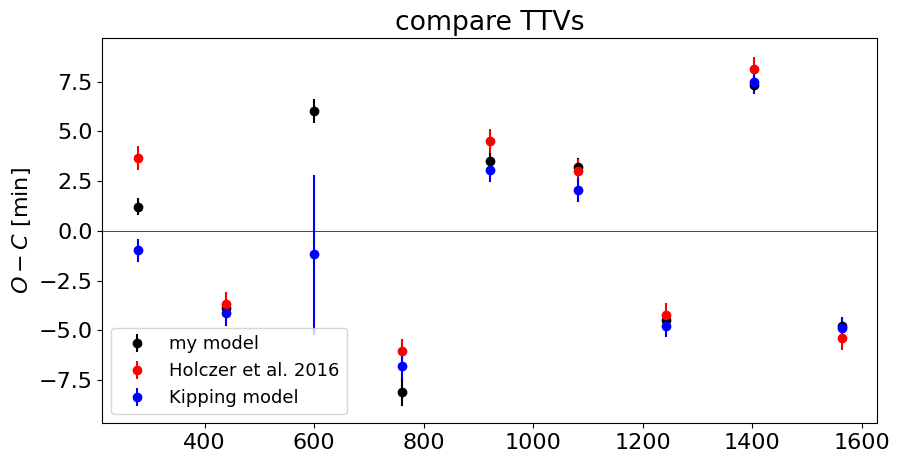

In [1092]:
t_offset = 2454900 - 2454833 

time_model = []
for ii in range(0,9):
    time_model.append(t0_median+(P_median*ii))
    #print(24. * 60. * (tts_median[ii]-time_model[ii]))
    #print(ttvs_median[ii])
    
    
    
print('')
print("holczer")
x_holczer = np.array([210.508782, 371.393408, 693.162660, 854.047286, 1014.931912, 1175.816538, 1336.701164, 1497.585790])
x_holczer += t_offset
y_holczer = []
epoch = 0
for time in x_holczer:
    if epoch == 2:
        epoch += 1
        
    #print(24. * 60. * (time-time_model[epoch]))
    y_holczer.append(24. * 60. * (time-time_model[epoch]))
    epoch+=1
    

y_holczer = np.array([3.6400, -3.6800, -6.0300, 4.5100, 3.0200, -4.2100, 8.1400, -5.3800])
yerr_holczer = np.array([6e-01, 6e-01, 6e-01, 6e-01, 6e-01, 6e-01, 6e-01, 6e-01])

x_kipping = np.array([55110.505627155893, 55271.387764127088, 55432.274166387979,
                      55593.154601972172, 55754.045764114046, 55914.929417273248, 
                      56075.808992459257, 56236.701851571495, 56397.577613172602])
x_kipping -= 54833 

for ii in range(0, len(x_holczer)):
    print(24.*60.*x_holczer[ii])
    
yerr_kipping = np.array([
    [0.000402962774, 0.000399917204],
    [0.000440256757, 0.000441709722],
    [0.002814652733, 0.002745562269],
    [0.00046894051, 0.000469475679],
    [0.000409040716, 0.000403825223],
    [0.000424959595, 0.000417035772],
    [0.000362309329, 0.000367076056],
    [0.000423798963, 0.000430076718],
    [0.000367674438, 0.000366104934]]).T
yerr_kipping = 24.*60.*yerr_kipping

print('')
print("kipping")
y_kipping = []
epoch = 0
for time in x_kipping:
    y_kipping.append(24. * 60. * (time-time_model[epoch]))
    #print(24. * 60. * (time-time_model[epoch]))
    epoch+=1
    
    

for ii in range(0, len(x_kipping)):
    print(24.*60.*x_kipping[ii])
    
'''    
# for TTVs comparison, read in times and then subtract out ephemeris information
0	55110.505627155893	0.000402962774	0.000399917204	1.087096278	0.580266395	0.575880774
1	55271.387764127088	0.000440256757	0.000441709722	-2.265761699	0.633969731	0.636062
2	55432.274166387979	0.002814652733	0.002745562269	0.523397485	4.053099936	3.953609668
3	55593.154601972172	0.00046894051	0.000469475679	-5.279457775	0.675274335	0.676044978
4	55754.045764114046	0.000409040716	0.000403825223	4.363930026	0.589018632	0.581508321
5	55914.929417273248	0.000424959595	0.000417035772	3.194382779	0.611941817	0.600531511
6	56075.808992459257	0.000362309329	0.000367076056	-3.847445866	0.521725434	0.528589521
7	56236.701851571495	0.000423798963	0.000430076718	8.23957926	0.610270507	0.619310473
8	56397.577613172602	0.000367674438	0.000366104934	-4.293811645	0.529451191	0.527191105
'''



fig, ax1 = plt.subplots(1, 1, figsize=(10, 5), sharex=True)


ax1.errorbar(tts_median, ttvs_median, yerr = ttvs_err, ls = '', marker = 'o', color = 'k', label = "my model")
ax1.errorbar(x_holczer, y_holczer, yerr = yerr_holczer, ls = '', marker = 'o', color = 'r', label = "Holczer et al. 2016")
ax1.errorbar(x_kipping, y_kipping, yerr = yerr_kipping, ls = '', marker = 'o', color = 'b', label = "Kipping model")

ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [min]")

ax1.legend(fontsize = 13, loc=3)
_ = ax1.set_title("compare TTVs") 